<a id='top'></a>

### 0_methods_B_tuning_3_find_best_fit.ipynb  

# Tuning: find best fit
This notebook does the postprocessing of the tuning runs and computes Mean Absolute Erorrs (MAEs) of model minus observations.  
They are saved in a total_table file together with the median, mean residence time (MRT) and k_ads_Pa_sum, k_ads_Th_sum as measures of total scavenging.  
Further analysis is done in tuning_analyse.ipynb to find the best fit run.

Steps: 
- **[Set up notebook](#setup-notebook)**
- **[Load observations dissolved - quick](#load-obsd)**
- **[Load observations particle-bound - quick](#load-obsp)**
- [Explore observations geotraces dissolved and explain choices](#explore-obsd) 
- [Explore observations geotraces particle-bound and explain choices](#explore-obsp) 
- **[Load model runs - quick](#load-model)**
- [Explore model runs](#explore-model)
- **[Compute MRT](#MRT)** 
- **[Compute median and k_ads_sum](#median-kads)** 
- **[Compute RMSEs of model-obs misfit](#RMSE)** 
- **[Compute MAEs of model-obs misfit](#MAE)**
- **[Export result](#export)**  
- Find best fit: see tuning_analyse.ipynb

**This notebook can be run/read by only executing the bold parts**

In [1]:
########### SETTINGS ###########
# set ensemble to 1 of: 1TU 2TU 3TU PAR 1P5 2P5 KDE
ensemble = '3P5'
################################

<a id='setup-notebook'></a>
# Set up notebook
[go to top](#top)

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [2]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################

# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here

## OR define modeldir depending on which system you are working on:
# if platform.system() == "Darwin":   # on Mac (e.g. laptop)
#    modeldir = Path('~/Documents/PHD/Bern3D/results')
# elif platform.system() == "Linux":  # on linux (e.g. cluster)
#    modeldir = Path('/storage/climatestor/Bern3dLPX/scheen/b3d_results')
# else:
#    raise Exception("unknown system", platform.system())

#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
import cartopy.crs as ccrs
import seaborn as sns

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# set a random run (the 1st run actually) as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / '1TU1000_PI'  

# in the model output, simulation year 0 is called 1765 CE (pre-industrial)
spinup_yr = 1765

## INFORMATION ON ENSEMBLES
# only used for ensemble '3TU'
all_runs_ws = range(0,14)
all_runs_kdes = range(100,118)
all_runs_sigmas_poc = range(200,221)
all_runs_sigmas_ca = range(300,319)
all_runs_sigmas_op = range(400,422)
all_runs_sigmas_du = range(500,521)
all_runs_sigmas_ne = range(600,619)
all_runs_all_sigmas = range(701,711)   # varying all sigmas from 'min of obs range' to 'max of obs range +50%'
all_runs_try_combined = range(800,810) # manual choices that combine optimal parameters that were result of the other 3TU runs

# only used for ensemble 'KDE':
kdes_runs_batch1 = list(range(0,20))+list(range(40,48))
kdes_runs_batch2 = list(range(20,40))+list(range(48,56))
kdes_runs_batch3 = list(range(56,84))

all_run_nrs = {'1TU' : range(0,2951),
               '2TU' : range(0,511),
               '3TU' : list(all_runs_ws)+list(all_runs_kdes)+list(all_runs_sigmas_poc)+list(all_runs_sigmas_ca)+list(all_runs_sigmas_op)
                       +list(all_runs_sigmas_du)+list(all_runs_sigmas_ne)+list(all_runs_all_sigmas)+list(all_runs_try_combined),
               'PAR' : ['_WS0000', '_WS0100', '_WS0500', '_WS1000', '_WS1500', '_WS2000', '_WS3000', '_WS4000', '_WS5000', 
                        '_PTCA00', '_PTCA01', '_PTCA02', '_PTCA03', '_PTCA04', '_PTCA05', '_PTCA06', '_PTCA07', '_PTCA08'],
               '1P5' : range(0,3006),
               '2P5' : range(0,3000),
               '3P5' : range(0,3000),
               'KDE' : kdes_runs_batch1+kdes_runs_batch2+kdes_runs_batch3}
# NOTE FOR 'PAR' ENSEMBLE: for this ensemble I messed up the naming. It went as: PAR_WS0001 and PAR_PTCA01
# quick fixes are implemented inside the functions
# it can be replaced now by 3TU, which also varies Ws and sigmajCa, but with other sigmas fixed at different vals that seem a bit better

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [ ]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<a id='load-obsd'></a>
# Load observations of dissolved Pa, Th - quick
from GEOTRACES IDP2021, Deng et al., Ng et al. and Pavia et al.  
IDP 2021 = Intermediate Data Product  
see obsdir/IDP_2021_log_how_downloaded.rtf  
[go to top](#top)

In [7]:
# load geotraces observations
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')
obs_d_incl_arctic = pd.concat([obs_d_geotraces_incl_arctic,obs_d_deng,obs_d_ng
                               ,obs_d_pavia], join='outer')  # for completeness; not used

[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

<ipython-input-7-d2443af5b823>:3: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE',


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [8]:
# observations of Pad, Thd on observation coords
obs_d

z_qc  z_bottom  lon_sim_0_to_360  \
lon       lat      z                                            
0.00000   -52.9560 380.400    0.0    2624.0               3.5   
                   500.000    0.0    2624.0               3.5   
                   999.900    0.0    2624.0               3.5   
0.00109   -51.8659 57.700     0.0    2640.0               3.5   
                   165.900    0.0    2640.0               3.5   
...                           ...       ...               ...   
186.21500 -53.8350 3501.243   NaN       NaN             185.0   
                   3999.365   NaN       NaN             185.0   
                   4500.535   NaN       NaN             185.0   
                   5000.069   NaN       NaN             185.0   
                   5247.235   NaN       NaN             185.0   

                             lon_sim_100_to_460  lat_sim        z_sim  cruise  \
lon       lat      z                                                            
0.00000   -52.9560 380.400                363.5    -54.0   377.094555  GIPY04   
                   500.000                363.5    -54.0   518.904447  GIPY04   
                   999.900                363.5    -54.0   982.009764  GIPY04   
0.00109   -51.8659 57.700                 363.5    -50.0    59.480928  GIPY04   
                   165.900                363.5    -50.0   149.938598  GIPY04   
...                                         ...      ...          ...     ...   
186.21500 -53.8350 3501.243               185.0    -54.0  3425.697606   pavia   
                   3999.365               185.0    -54.0  4060.409965   pavia   
                   4500.535               185.0    -54.0  4415.270321   pavia   
                   5000.069               185.0    -54.0  4797.743518   pavia   
                   5247.235               185.0    -54.0  4797.743518   pavia   

                                  station  pressure  pressure_qc   Pad  \
lon       lat      z                                                     
0.00000   -52.9560 380.400             65     384.1          0.0   NaN   
                   500.000             65     505.1          0.0   NaN   
                   999.900             65    1011.3          0.0   NaN   
0.00109   -51.8659 57.700    62 (Super 4)      58.2          0.0   NaN   
                   165.900   62 (Super 4)     167.4          0.0   NaN   
...                                   ...       ...          ...   ...   
186.21500 -53.8350 3501.243            15       NaN          NaN  5.58   
                   3999.365            15       NaN          NaN  5.78   
                   4500.535            15       NaN          NaN  5.71   
                   5000.069            15       NaN          NaN  5.43   
                   5247.235            15       NaN          NaN  5.81   

                             Pad_err Pad_qc        Thd   Thd_err  Thd_qc  \
lon       lat      z                                                       
0.00000   -52.9560 380.400       NaN    9.0   9.915253  0.127193     1.0   
                   500.000       NaN    9.0  12.790078  0.168823     1.0   
                   999.900       NaN    9.0  16.094715  0.190595     1.0   
0.00109   -51.8659 57.700        NaN    9.0   0.915358  0.012224     1.0   
                   165.900       NaN    9.0   2.141705  0.021980     1.0   
...                              ...    ...        ...       ...     ...   
186.21500 -53.8350 3501.243     0.11    NaN  11.650000  0.110000     NaN   
                   3999.365     0.13    NaN  12.540000  0.150000     NaN   
                   4500.535     0.14    NaN  13.600000  0.160000     NaN   
                   5000.069     0.16    NaN  13.700000  0.140000     NaN   
                   5247.235     0.13    NaN  13.530000  0.180000     NaN   

                             QV:ODV:SAMPLE  
lon       lat      z                        
0.00000   -52.9560 380.400             1.0  
                   500.000             1.0

In [9]:
# observations of Pad, Thd on nearest model grid cell (averaged when multiple obs present in 1 grid cell)
obs_d_ave

Pad       Thd   Pad_err  \
lat_sim lon_sim_100_to_460 z_sim                                       
-70.0   349.5              19.088927    0.571656  1.851687  0.329533   
                           149.938598   0.946553  2.974546  0.303997   
        356.5              59.480928    1.124049  2.603894  0.322114   
                           103.015962    1.01556   2.64848  0.236357   
                           200.512438   1.750369  6.636425  0.345175   
...                                          ...       ...       ...   
 57.5   335.5              2198.977326      1.47      0.96      0.14   
                           2635.351809      1.94      1.35      0.13   
                           2879.323748  1.664413  1.786474  0.098698   
                           3142.279938  1.806038  2.546746  0.071896   
                           4060.409965      2.02       2.5      0.18   

                                         Thd_err  cruise  
lat_sim lon_sim_100_to_460 z_sim                          
-70.0   349.5              19.088927    0.232304  GIPY05  
                           149.938598   0.427319  GIPY05  
        356.5              59.480928     0.23358  GIPY05  
                           103.015962   0.220982  GIPY05  
                           200.512438   0.529465  GIPY05  
...                                          ...     ...  
 57.5   335.5              2198.977326      0.13    deng  
                           2635.351809      0.14    deng  
                           2879.323748  0.083603    deng  
                           3142.279938  0.080554    deng  
                           4060.409965      0.17    deng  

[1108 rows x 5 columns]

In [10]:
# number of obs that were averaged in this grid cell location 
obs_d_ave_num.loc[:,('Pad','Thd',)]

Pad  Thd
lat_sim lon_sim_100_to_460 z_sim                
-70.0   349.5              19.088927    1.0  1.0
                           149.938598   1.0  1.0
        356.5              59.480928    1.0  1.0
                           103.015962   1.0  1.0
                           200.512438   1.0  1.0
...                                     ...  ...
 85.0   425.0              1499.977687  1.0  1.0
                           2879.323748  1.0  1.0
                           3425.697606  1.0  1.0
                           4060.409965  1.0  1.0
                           4415.270321  1.0  1.0

[1426 rows x 2 columns]

<a id='load-obsp'></a>
# Load observations of particle-bound Pa, Th from GEOTRACES IDP2021 - quick
IDP 2021 = Intermediate Data Product  
see obsdir/IDP_2021_log_how_downloaded.rtf  
[go to top](#top)

In [18]:
# LOAD WITH NEW COLUMNS Pap, Thp THAT COMBINE SPT,LPT,TP and 
# extra columns Pap_type, Thp_type which keep track of the origin
# also with only keeping good quality measurements
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.


<a id='explore-obsd'></a>
# Explore dissolved geotraces observations and explain choices
Aware! In this section we use 'obs_d' for obs_d_geotraces, whereas in rest of notebook 'obs_d' must be a concatenation of geotraces and the other studies deng pavia ng.  
[go to top](#top)

In [22]:
# # find out in which year cruises took place (keep meta data while loading)

# fnobs = obsdir / 'Pad_Thd_IDP2021.txt'

# obs_d = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', drop_meta_data=False, good_quality=True)
# [obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

# yr = [int(string[0:4]) for string in obs_d["yyyy-mm-ddThh:mm:ss.sss"]]
# np.unique(yr)

# # => 2008-2017 for dissolved

<ipython-input-22-f5b07ca16309>:5: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  obs_d = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', drop_meta_data=False, good_quality=True)


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

### Load obs

In [13]:
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'

obs_d = f.get_obs_geotraces(fnobs, dissolved_type='ALL', drop_meta_data=True, good_quality=False)
# dissolved_type='ALL' => keeping all types of columns for now for this data exploration
# good_quality='false' => keeping all observations, good and bad quality

<ipython-input-13-f54537914fc0>:3: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  obs_d = f.get_obs_geotraces(fnobs, dissolved_type='ALL', drop_meta_data=True, good_quality=False)


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2256  rows after deleting nans.


Recall that indexing in pandas works like:   
`obs_d.iloc[:,1]      # rows, cols via number`  
`obs_d.loc[201,'lat'] # rows, cols via names of index var resp column name`  
In order to access our dataframe via lat, lon and z, we need these coordinates (lon,lat,z) to be in a multi-index.

### Recap: how to access data in a multi-index pandas dataframe?
Examples in the next cell  

Following tutorial: https://towardsdatascience.com/accessing-data-in-a-multiindex-dataframe-in-pandas-569e8767201d


In [14]:
# examples without using tuples (can be ambiguous):
obs_d.loc[0.00189, 'z_bottom']  # row lon=0.00189 (first of the index) and column z_bottom
obs_d.loc[0.00189, :]           # row lon=0.00189 (first of the index) and all columns
obs_d.loc[:,'Pad_BOTTLE']       # all rows; column Pad
obs_d.loc[359.99814, -66.4999]  # lon=359.99814, lat=-66.4999 => only selecting rows here so ambiguous how to read .loc[,]

# BETTER: same examples with using tuples to group row and column selections:
# => not ambiguous and note that the bold headers stay (if extra commas are put in)
obs_d.loc[(0.00189,), ('z_bottom',)]   # row lon=0.00189 (first of the index) and column z_bottom
obs_d.loc[(0.00189,), :]               # row lon=0.00189 (first of the index) and all columns
obs_d.loc[:, ('Pad_BOTTLE',)]          # all rows; column Pad
obs_d.loc[(359.99814, -66.4999)]       # same as obs_d.loc[(359.99814, -66.4999), :]   # lon=359.99814, lat=--66.4999

obs_d.loc[(359.99814, -66.4999), ('Pad_BOTTLE',)]   # show Pad for a certain lon, lat

# pass a list of labels to select multiple rows or columns:
obs_d.loc[(359.99814, -66.4999), ('Pad_BOTTLE','Thd_BOTTLE')]
obs_d.loc[([0.00189,359.99814]), ('Pad_BOTTLE',)]   # deleted the lat=-66.4999 here, because lats are different at different lons

# SLICING BY GIVING IN EXACT COORDS via start:stop:step is correctly done in a tuple:
# obs_d.loc[0.00189:359.99814, 'Pad_BOTTLE']        # slicing works without tuples (for 1st index only(?))
# obs_d.loc[(0.00189:359.99814,), ('Pad_BOTTLE',)]  # but analogous with tuples gives syntax error
obs_d.loc[(0.00189,):(359.99814,), ('Pad_BOTTLE',)]  # this is the correct way with tuples to slice index 1
obs_d.loc[(359.99814,-66.4999,):(359.99814,-58.1989,),('Pad_BOTTLE','Thd_BOTTLE')]  # slice index 1 and 2 (index 1 the same)
obs_d.loc[(0.00189,-66.4999,):(359.99814,-58.1989,),('Pad_BOTTLE','Thd_BOTTLE')]     # slice index 1 and 2 (index 1 different)

# SLICING WHATEVER WE WANT
# We can use : to select all content when retrieving data via the first-level index. 
# However, we will be getting SyntaxError when using it with a multi-level index.
# The correct way to select all content on a specific index level is to use slice(None):
obs_d.loc[(slice(None), slice(None), slice(0,100)),('Pad_BOTTLE','Pad_BOTTLE_err',)]  # show all Pad, Pad_err in upper 100 meter

# SLICING FROM IN A LIST
obs_d[obs_d.cruise.isin(['GA02','GA03'])]

# skipping part of tutorial #5 on .xs() (cross section) and #6 on index slice package

z_qc  z_bottom cruise station  pressure  pressure_qc  \
lon     lat     z                                                              
30.284  84.3896 50.1     0.0    4057.0   GN04     050      50.6          0.0   
                100.2    0.0    4057.0   GN04     050     101.3          0.0   
                299.9    0.0    4057.0   GN04     050     303.4          0.0   
                500.4    0.0    4057.0   GN04     050     506.4          0.0   
                750.4    0.0    4057.0   GN04     050     759.9          0.0   
...                      ...       ...    ...     ...       ...          ...   
306.630 56.1206 2297.7   0.0    3312.0   GN02      K1    2331.7          0.0   
                2447.0   0.0    3312.0   GN02      K1    2484.1          0.0   
                2598.4   0.0    3312.0   GN02      K1    2638.8          0.0   
                2750.1   0.0    3312.0   GN02      K1    2793.8          0.0   
                2998.8   0.0    3312.0   GN02      K1    3048.3          0.0   

                        Pad_BOTTLE  Pad_BOTTLE_err Pad_BOTTLE_qc  Pad_FISH  \
lon     lat     z                                                            
30.284  84.3896 50.1      0.524766        0.174922             1       NaN   
                100.2     0.524766        0.174922           1.0       NaN   
                299.9     0.699688        0.174922           1.0       NaN   
                500.4     0.349844        0.174922           1.0       NaN   
                750.4     1.399375        0.174922           1.0       NaN   
...                            ...             ...           ...       ...   
306.630 56.1206 2297.7    1.188388        0.096120             1       NaN   
                2447.0    2.446680        0.166025             1       NaN   
                2598.4    2.970969        0.157287             4       NaN   
                2750.1    1.328198        0.052429             1       NaN   
                2998.8    0.978672        0.069905             4       NaN   

                        ...  Thd_UWAY  Thd_UWAY_err  Thd_UWAY_qc  \
lon     lat     z       ...                                        
30.284  84.3896 50.1    ...       NaN           NaN          9.0   
                100.2   ...       NaN           NaN          9.0   
                299.9   ...       NaN           NaN          9.0   
                500.4   ...       NaN           NaN          9.0   
                750.4   ...       NaN           NaN          9.0   
...                     ...       ...           ...          ...   
306.630 56.1206 2297.7  ...       NaN           NaN          9.0   
                2447.0  ...       NaN           NaN          9.0   
                2598.4  ...       NaN           NaN          9.0   
                2750.1  ...       NaN           NaN          9.0   
                2998.8  ...       NaN           NaN          9.0   

                        Thd_BOAT_PUMP  Thd_BOAT_PUMP_err  Thd_BOAT_PUMP_qc  \
lon     lat     z                                                            
30.284  84.3896 50.1              NaN                NaN               9.0   
                100.2             NaN                NaN               9.0   
                299.9             NaN                NaN               9.0   
                500.4             NaN                NaN               9.0   
                750.4             NaN                NaN               9.0   
...                               ...                ...               ...   
306.630 56.1206 2297.7            NaN                NaN               9.0   
                2447.0            NaN                NaN               9.0   
                2598.4            NaN                NaN               9.0   
                2750.1            NaN                NaN               9.0   
                2998.8            NaN                NaN               9.0   

                        Thd_SUBICE_PUMP  Thd_SUBICE_PUMP_err  \
lon 

### Check if data is complete
The cruises that should be in there are:  
Pa-231: GA02, GA03 (west and east) GIPY05 (west, center and east), GN01 (west and east), GN03, GPc01 (west and east), GP16  
Th-230: same list plus GA10, GIpr05 (north and south; Indin ocean)  

Sources (with map):    
https://egeotraces.org/?group=Natural%20Radionuclides,variable=Pa_231%20dissolved  
https://egeotraces.org/?group=Natural%20Radionuclides,variable=Th_230%20dissolved

In [15]:
cruises = np.unique(obs_d.cruise)
# manually set colours such that e.g. GAc02 and GA02 are grouped together
cols = {'GA02':'C0', 'GAc02':'C0', 'GA03':'C1', 'GAc03':'C1', 'GA10':'C2', 
        'GIPY04':'C3', 'GIPY05':'C4','GSc02':'C5','GIpr05':'C6', 
        'GN01':'C7', 'GN02':'C8', 'GN03':'C9', 'GN04':'C10', 
        'GP16':'C11', 'GPc01':'C12'}

cruises
# all required cruises are in the list; but even extra are: GN02, GN04, GIPY04, GSc02 (south west indian / southern ocean)

array(['GA02', 'GA03', 'GA10', 'GAc02', 'GAc03', 'GIPY04', 'GIPY05',
       'GIpr05', 'GN01', 'GN02', 'GN03', 'GN04', 'GP16', 'GPc01', 'GSc02'],
      dtype=object)

RHS: Black dots are printed at the bottom depth of each station location



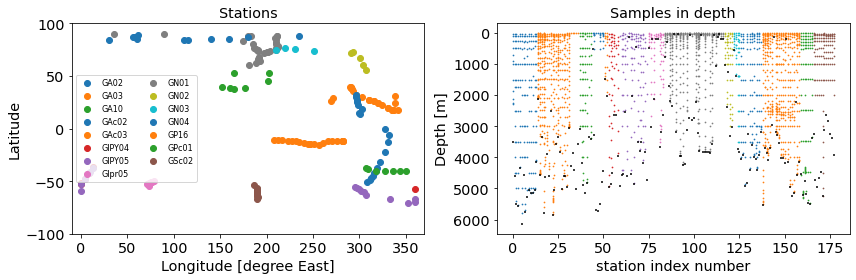

In [16]:
## DISTRIBUTION OF DATA POINTS:    VERSION FOR PA AND TH TOGETHER
# plots all data in obs OBJECT

##### SETTINGS ############
small_dots = False  # for col 2; set True if many many data
###########################

## plot
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].set_title('Stations')
ax[1].set_title('Samples in depth')
counter = 0  # used for x axis (index number of station)
for m,this_cruise in enumerate(cruises):
    # prepare plotting objects
    this_cruise_obs = obs_d.where(obs_d.cruise==this_cruise).dropna(how='all')
    [stations, stations_lon, stations_lat, stations_z_bottom, stations_z] = f.prepare_stations_z_plot(this_cruise_obs)
    
    # plot col 1
    ax[0].scatter(stations_lon, stations_lat, color=cols[this_cruise], label=this_cruise)
    
    # plot col 2
    for n,this_station in enumerate(stations):
        i_station = counter + n
        if small_dots:
            ax[1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                          s=0.1, color=cols[this_cruise])                              # expand [n] on x axis to [n, n, ... , n] with same length as y
            ax[1].scatter(i_station, stations_z_bottom[n], s=1, marker='_', color='k') # plot z_bottom as a black horizontal line
        else:
            ax[1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                          s=0.5, color=cols[this_cruise])
            ax[1].scatter(i_station, stations_z_bottom[n], s=2, marker='_', color='k') 
    counter = counter + len(stations_z)
    
ax[0].set_xlabel('Longitude [degree East]')
ax[0].set_ylabel('Latitude')
ax[0].set_ylim(-100,100)
ax[0].set_xlim(-10,370)
ax[0].legend(loc='center left', fontsize=8, ncol=2)
print('RHS: Black dots are printed at the bottom depth of each station location\n')
ax[1].set_xlabel('station index number')
ax[1].set_ylabel('Depth [m]')
ax[1].invert_yaxis()
plt.tight_layout()
# plt.savefig(savedir / 'data_spread_pad_thd_together.png', dpi=500)
plt.savefig(savedir / 'data_spread_pad_thd_together.pdf')
plt.show()

# Left panel is consistent with the tracks in the downloaded figure with Africa on the left hand side border (hard to see);
# the west-east track just south of the equator is in the Pacific

Reduced dataset from  2256  rows to  2005  rows after deleting nans.
Reduced dataset from  2256  rows to  2252  rows after deleting nans.
RHS: Black dots are printed at the bottom depth of each station location


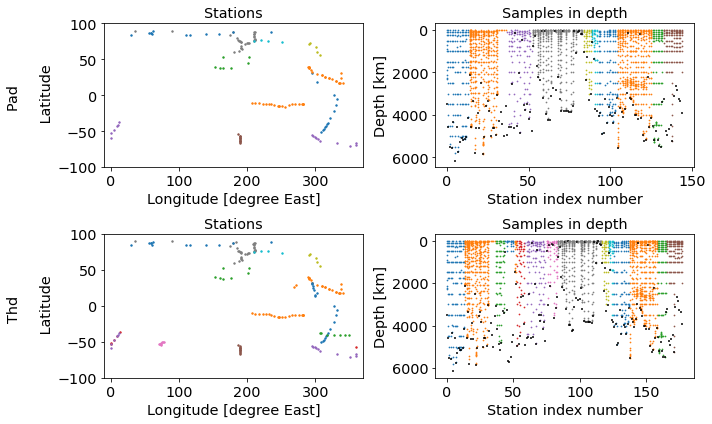

In [17]:
## DISTRIBUTION OF DATA POINTS:    VERSION FOR PA AND TH SEPARATELY
# plots all data in obs OBJECT

##### SETTINGS ############
small_dots_stations = True
small_dots = False  # set True if many many data
land = False         # not working yet
legend = False
###########################

obs_Pa = f.take_data_subset_nonnan(obs_d.loc[:,('Pad_BOTTLE','Pad_BOAT_PUMP','Pad_SUBICE_PUMP','Pad_FISH','Pad_UWAY',
                                              'station','z_bottom','cruise')])
obs_Th = f.take_data_subset_nonnan(obs_d.loc[:,('Thd_BOTTLE','Thd_BOAT_PUMP','Thd_SUBICE_PUMP','Thd_FISH','Thd_UWAY',
                                              'station','z_bottom','cruise')])

# Calculate the landmask (used in surface plots)
if "res_entire" not in globals():
    if ensemble == 'PAR':
        runid = all_run_nrs[ensemble][0]   # for example
    else:
        runid = all_run_nrs[ensemble][0] + 1000  # must be ID
    [res_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                        ensemble=ensemble, convert_unit_to_obs=True)
land_mask = f.get_landmask(res_entire)
X,Y = np.meshgrid(res_entire.lon_u, res_entire.lat_u) # u grid because pcolor needs left bottom corner

## plot
fig, ax = plt.subplots(2,2, figsize=(10,6))

for row, this_obs in enumerate([obs_Pa, obs_Th]):
    
    ax[row,0].set_title('Stations')
    ax[row,1].set_title('Samples in depth')

    ## prepare plotting objects
    counter = 0  # used for x axis (index number of station)
    for m,this_cruise in enumerate(cruises):
        # prepare plotting objects
        this_cruise_obs = this_obs.where(this_obs.cruise==this_cruise).dropna(how='all')
        [stations, stations_lon, stations_lat, stations_z_bottom, stations_z] = f.prepare_stations_z_plot(this_cruise_obs)

        # plot col 1
        if small_dots_stations:
            ax[row,0].scatter(stations_lon, stations_lat, s=2, color=cols[this_cruise], label=this_cruise)
        else:
            ax[row,0].scatter(stations_lon, stations_lat, color=cols[this_cruise], label=this_cruise)

        # plot col 2
        for n,this_station in enumerate(stations):
            i_station = counter + n
            if small_dots:
                ax[row,1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                                  s=0.1, color=cols[this_cruise])                              # expand [n] on x axis to [n, n, ... , n] with same length as y
                ax[row,1].scatter(i_station, stations_z_bottom[n], s=1, marker='_', color='k') # plot z_bottom as a black horizontal line
            else:
                ax[row,1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                                  s=0.5, color=cols[this_cruise])
                ax[row,1].scatter(i_station, stations_z_bottom[n], s=2, marker='_', color='k') 
        counter = counter + len(stations_z)    


    ax[row,0].set_xlabel('Longitude [degree East]')
    if land:
        ax[row,0].pcolor(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[row,0].set_ylim(-100,100)
    ax[row,0].set_xlim(-10,370)
    if legend:
        ax[row,0].legend(loc='center left', fontsize=8, ncol=2)
    
    ax[row,1].set_xlabel('Station index number')
    ax[row,1].set_ylabel('Depth [km]')
    ax[row,1].invert_yaxis()
    
ax[0,0].set_ylabel('Pad \n \n Latitude')
ax[1,0].set_ylabel('Thd \n \n Latitude')


print('RHS: Black dots are printed at the bottom depth of each station location')

plt.tight_layout()
# plt.savefig(savedir / 'data_spread_pad_thd_per_row.png', dpi=500)
plt.savefig(savedir / 'data_spread_pad_thd_per_row.pdf')
plt.show()

### Find out which concentration measurements to use

**Which types of concentration are relevant?** For Pad and Thd the following exist. I added description from excel in https://www.geotraces.org/wp-content/uploads/2020/02/IDP2021_DissolvedTEIS_Ligands_SI_Assignment_27February2020_web.xlsx:
- CONC_BOTTLE: Samples collected using a bottle sampling device
- CONC_PUMP: Any kind of pump (e.g., in situ or deck)  
  => CONC_BOATPUMP  
  => CONC_SUBICEPUMP
- CONC_FISH 'Towed fish': Samples collected using a trace metal clean towed fish
- CONC_UWAY 'Ship's underway': Samples collected using a ship's underway seawater sampling system  

**Conclusion: only use CONC_BOTTLE (as was done above under Load dissolved observations - quick)**

Reduced dataset from  2256  rows to  2200  rows after deleting nans.
Reduced dataset from  2256  rows to  34  rows after deleting nans.
Reduced dataset from  2256  rows to  3  rows after deleting nans.
Reduced dataset from  2256  rows to  1  rows after deleting nans.
Reduced dataset from  2256  rows to  18  rows after deleting nans.
Reduced dataset from  34  rows to  34  rows after deleting nans.
RHS: Black dots are printed at the bottom depth of each station location
RHS: Black dots are printed at the bottom depth of each station location


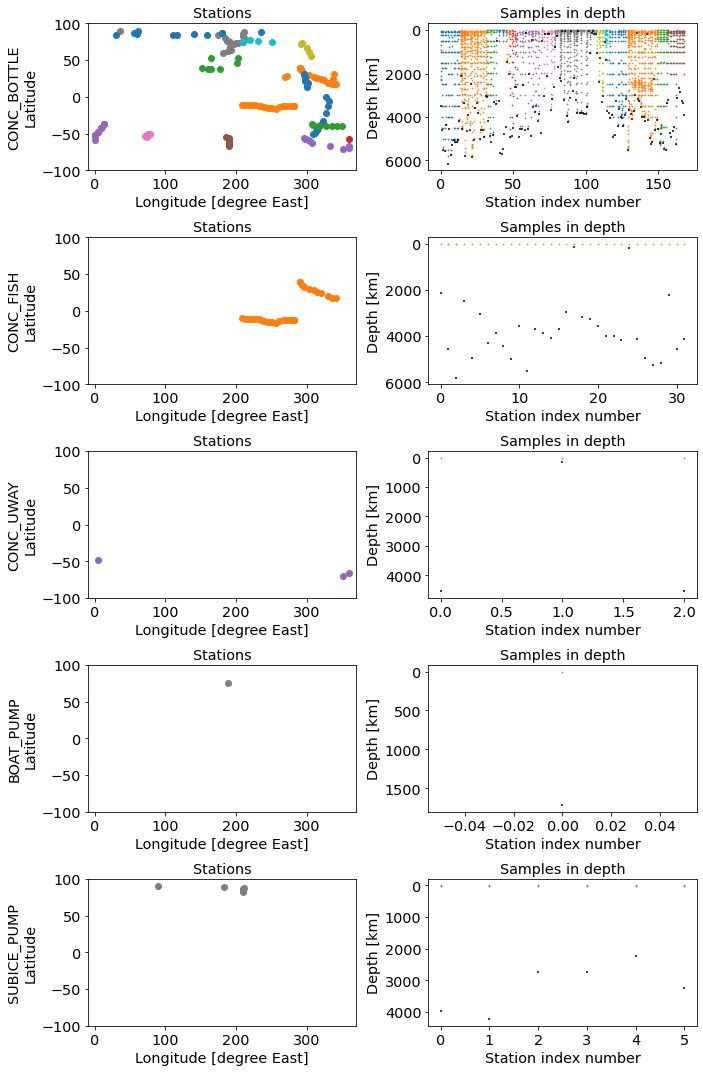

In [18]:
# ================= TAKES A WHILE (< 5 MIN)========================

## DISTRIBUTION OF DATA POINTS:    VERSION PER DATA TYPE
# (does not depends on obs object; newly loads in data)

##### SETTINGS ############
small_dots_stations = False
small_dots = False   # set True if many many data
land = False         # TODO not working yet
legend = False
###########################

## prepare plotting objects
obs_bottle = f.take_data_subset_nonnan(obs_d.loc[:,('z_qc','z_bottom','cruise','station','pressure', 'pressure_qc','Pad_BOTTLE','Thd_BOTTLE',
                                                  'Pad_BOTTLE_err','Thd_BOTTLE_err','Pad_BOTTLE_qc','Thd_BOTTLE_qc','QV:ODV:SAMPLE')])
# keep more columns for obs_bottle because we will keep using it later on
obs_fish = f.take_data_subset_nonnan(obs_d.loc[:,('cruise','station','z_bottom','Pad_FISH','Thd_FISH')])
obs_uway = f.take_data_subset_nonnan(obs_d.loc[:,('cruise','station','z_bottom','Pad_UWAY','Thd_UWAY')])
obs_boat_pump = f.take_data_subset_nonnan(obs_d.loc[:,('cruise','station','z_bottom','Pad_BOAT_PUMP','Thd_BOAT_PUMP')])
obs_subice_pump = f.take_data_subset_nonnan(obs_d.loc[:,('cruise','station','z_bottom','Pad_SUBICE_PUMP','Thd_SUBICE_PUMP')])

obs_fish = f.take_data_subset_nonnan(obs_fish)

## plot
fig, ax = plt.subplots(5,2, figsize=(10,15))

ax[0,0].set_title('Stations\n')
ax[0,1].set_title('Samples in depth\n')
ax[4,0].set_xlabel('Longitude [degree East]')
ax[4,1].set_xlabel('Station index number')

print('RHS: Black dots are printed at the bottom depth of each station location')
row_titles = ['CONC_BOTTLE', 'CONC_FISH', 'CONC_UWAY', 'BOAT_PUMP', 'SUBICE_PUMP']
for row, this_obs_type in enumerate([obs_bottle, obs_fish, obs_uway, obs_boat_pump, obs_subice_pump]):
    
    ax[row,0].set_title('Stations')
    ax[row,1].set_title('Samples in depth')

    ## prepare plotting objects
    counter = 0  # used for x axis (index number of station)
    for m,this_cruise in enumerate(cruises):
        # prepare plotting objects
        this_cruise_obs = this_obs_type.where(this_obs_type.cruise==this_cruise).dropna(how='all')
        [stations, stations_lon, stations_lat, stations_z_bottom, stations_z] = f.prepare_stations_z_plot(this_cruise_obs)

        # plot col 1
        if small_dots_stations:
            ax[row,0].scatter(stations_lon, stations_lat, s=2, color=cols[this_cruise], label=this_cruise)
        else:
            ax[row,0].scatter(stations_lon, stations_lat, color=cols[this_cruise], label=this_cruise)

        # plot col 2
        for n,this_station in enumerate(stations):
            i_station = counter + n
            if small_dots:
                ax[row,1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                                  s=0.1, color=cols[this_cruise])                              # expand [n] on x axis to [n, n, ... , n] with same length as y
                ax[row,1].scatter(i_station, stations_z_bottom[n], s=1, marker='_', color='k') # plot z_bottom as a black horizontal line
            else:
                ax[row,1].scatter([i_station]*len(stations_z[n]), stations_z[n], 
                                  s=0.5, color=cols[this_cruise])
                ax[row,1].scatter(i_station, stations_z_bottom[n], s=2, marker='_', color='k') 
        counter = counter + len(stations_z)    

    ax[row,0].set_xlabel('Longitude [degree East]')
    ax[row,0].set_ylabel(row_titles[row] + '\nLatitude')
    if land:
        ax[row,0].pcolor(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[row,0].set_ylim(-100,100)
    ax[row,0].set_xlim(-10,370)
    if legend:
        ax[1,0].legend(loc='center left', fontsize=8, ncol=2)
    
    ax[row,1].set_xlabel('Station index number')
    ax[row,1].set_ylabel('Depth [km]')
    ax[row,1].invert_yaxis()

print('RHS: Black dots are printed at the bottom depth of each station location')
    
plt.tight_layout()
plt.savefig(savedir / 'data_spread_pad_thd_per_type.pdf')

# Left panel seemed consistent with the tracks in the downloaded figure
# We see Africa on the left hand side border (before dropping nans succesfull); the horizontal track ca along the equator is in the Pacific

Summary of print statements:   
- Total dataset contained 96184 rows including nans (stations or depths were vars other than Pad, Thd types were measured).
- Pad and Thd BOTTLE:  2200  rows
- Pad and Thd FISH:  34  rows (close to surface)
- Pad and Thd UWAY:  3  rows
- Pad and Thd BOAT_PUMP:  1  rows
- Pad and Thd SUBICE_PUMP:  18  rows

In [19]:
print('maximum depth [m] where observations occur:')
print('BOTTLE:', np.vstack(obs_bottle.index)[:,2].max())
print('FISH:', np.vstack(obs_fish.index)[:,2].max())
print('UWAY:', np.vstack(obs_uway.index)[:,2].max())
print('BOAT_PUMP:', np.vstack(obs_boat_pump.index)[:,2].max())
print('SUBICE_PUMP:', np.vstack(obs_subice_pump.index)[:,2].max())

maximum depth [m] where observations occur:
BOTTLE: 5815.3
FISH: 5.0
UWAY: 7.0
BOAT_PUMP: 1.0
SUBICE_PUMP: 20.0


Because all types other than BOTTLE are very rare and occur close to the surface, I don't take them into account. So I only consider BOTTLE.

In [20]:
# now constrain observations only to BOTTLE
obs_d = obs_bottle.rename(columns={'Pad_BOTTLE':'Pad','Thd_BOTTLE':'Thd','Pad_BOTTLE_err':'Pad_err',
                                   'Thd_BOTTLE_err':'Thd_err','Pad_BOTTLE_qc':'Pad_qc','Thd_BOTTLE_qc':'Thd_qc'})

### Drop data of bad quality
**Quality flags** are given in columns with quality control variables, named var_qc or var_qv. Their meaning is found here: https://vocab.seadatanet.org/v_bodc_vocab_v2/browse.asp?order=conceptid&formname=search&screen=0&lib=l20&v0_0=&v1_0=conceptid%2Cpreflabel%2Caltlabel%2Cdefinition%2Cmodified&v2_0=0&v0_1=&v1_1=conceptid&v2_1=3&v0_2=&v1_2=preflabel&v2_2=3&v0_3=&v1_3=altlabel&v2_3=3&v0_4=&v1_4=modified&v2_4=9&v0_5=&v1_5=modified&v2_5=10&x=27&y=12&v1_6=&v2_6=&v1_7=&v2_7=  

When loading data as .nc we also found this description, but it seems not relevant for our .txt data:  
flag_values : [48 49 50 51 52 53 54 55 56 57 65 81]  
flag_meanings :  
no_quality_control good_value probably_good_value probably_bad_value bad_value changed_value value_below_detection value_in_excess interpolated_value missing_value value_phenomenon_uncertain value_below_limit_of_quantification   

Archive could to find number of occurrences of e.g. 'Q':  
`from collections import Counter`  
`Counter([f'{x} ({type(x)})' for x in obs_d.iloc[:,21].values])`  

**Conclusion: given the high number of quality range 1 (1912 Pad + 2160 Thd) and the low accumulated number of the others (45 Pad + 36 Thd), which are <3%, we only use quality range 1 (as was done above under Load dissolved observations - quick)**

In [24]:
# look at this separate column
print('general quality values of sample:')
np.unique(obs['QV:ODV:SAMPLE']) 
# 1 = good value everywhere => OK

general quality values of sample:


array([1.])

In [25]:
# in Thd_qc neatly only floats appear:
print('quality values of Thd:')
np.unique(obs_d.Thd_qc)

quality values of Thd:


array([1., 2., 3., 4., 5., 9.])

In [26]:
# for Pad_qc unique not working because also strings appear: a bit of a mess:
Pad_qc_unique = []
for qc in obs_d.Pad_qc:
    if qc not in Pad_qc_unique:
        Pad_qc_unique.append(qc)
print('quality values of Pad:')
Pad_qc_unique

quality values of Pad:


[9.0, 1.0, '1', 5.0, 4.0, '9', 3.0, '2', '3', 2.0, '6', '4', 'Q']

In [27]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Pad_qc:')
Counter([f'{x} ({type(x)})' for x in obs_d.Pad_qc])

Pad_qc:


Counter({"9.0 (<class 'float'>)": 171,
         "1.0 (<class 'float'>)": 1487,
         "1 (<class 'str'>)": 425,
         "5.0 (<class 'float'>)": 3,
         "4.0 (<class 'float'>)": 1,
         "9 (<class 'str'>)": 72,
         "3.0 (<class 'float'>)": 7,
         "2 (<class 'str'>)": 1,
         "3 (<class 'str'>)": 1,
         "2.0 (<class 'float'>)": 1,
         "6 (<class 'str'>)": 11,
         "4 (<class 'str'>)": 6,
         "Q (<class 'str'>)": 14})

In [28]:
print('Thd_qc:')
Counter([f'{x} ({type(x)})' for x in obs_d.Thd_qc])

Thd_qc:


Counter({"1.0 (<class 'float'>)": 2160,
         "3.0 (<class 'float'>)": 6,
         "5.0 (<class 'float'>)": 3,
         "9.0 (<class 'float'>)": 4,
         "2.0 (<class 'float'>)": 20,
         "4.0 (<class 'float'>)": 7})

**Summary of quality variables:**  
1 good value:   
Pad 1912  Thd 2160  

2 probably good value:  
Pad 2  Thd 20  

3 probably bad value:  
(Data value recognised as unusual during quality control that forms part of a feature that is probably inconsistent with real phenomena.)  
Pad 8  Thd 6

4 bad value: An obviously erroneous data value.  
Pad 7  Thd 7  

5 changed value:  
(Data value adjusted during quality control. Best practice strongly recommends that the value before the change be preserved in the data or its accompanying metadata.)  
Pad 3  Thd 3  

6 value below detection:  
(The level of the measured phenomenon was less than the limit of detection (LoD) for the method employed to measure it. The accompanying value is the detection limit for the technique or zero if that value is unknown.)  
Pad 11  Thd 0  

9 missing value  
(JS: this basically means Pad is measured and Thd is not or vice versa)  
Pad 243  Thd 4  

Q value below limit of quantification:  
(Level of the measured phenomenon was less than the limit of quantification (LoQ). The accompanying value is the limit of quantification for the analytical method.)  
Pad 14  Thd 0

**Sum:**  
Pad 2200  Thd 2200 (correct; =nr of rows in obs)  
without nans (value 9) we should have:  
Pad 1957  Thd 2196  

Conclusion: given the high number of quality range 1 (1912 Pad + 2160 Thd) and the low accumulated number of the others (45 Pad + 36 Thd), which are <3%, we only use quality range 1.

In [ ]:
## restrain observations to only quality value 1; 
# this is also done if directly loading obs via .get_obs_geotraces(kwargs, good_quality=True)
obs_d = f.restrict_obs_to_good_quality(obs_d)

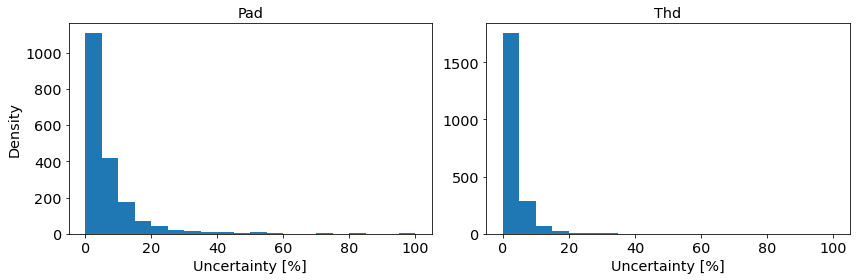

min, average and max measurement uncertainty for Pad [%]: 0.39 14.68 12203.42
min, average and max measurement uncertainty for Thd [%]: 0.13 3.63 366.67
For Pad:  57.9 % of measurements has uncertainty of < 5%;  22.0 % has uncertainty of 5-10%;
For Thd:  81.1 % of measurements has uncertainty of < 5%;  13.2 % has uncertainty of 5-10%;


<Figure size 432x288 with 0 Axes>

In [84]:
# investigate measurement uncertainties
nr_bins = 20

Pad_uncertainty_percentage = (obs_d.Pad_err / obs_d.Pad * 100).dropna(how='all')
Thd_uncertainty_percentage = (obs_d.Thd_err / obs_d.Thd * 100).dropna(how='all')

## plot
fig, ax = plt.subplots(1,2, figsize=(12,4))

obj = Pad_uncertainty_percentage.values
n,bins,patches = ax[0].hist(obj, bins=nr_bins, range=(0,100))
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Uncertainty [%]')
ax[0].set_title('Pad')

obj = Thd_uncertainty_percentage.values
n,bins,patches = ax[1].hist(obj, bins=nr_bins, range=(0,100))
ax[1].set_xlabel('Uncertainty [%]')
ax[1].set_title('Thd')

plt.tight_layout()
plt.show()
plt.savefig(savedir / 'uncertainty_dissolved_geotraces.pdf')

## print info
print('min, average and max measurement uncertainty for Pad [%]:', np.round(Pad_uncertainty_percentage.min(),2), 
      np.round(Pad_uncertainty_percentage.mean(),2), np.round(Pad_uncertainty_percentage.max(),2))
print('min, average and max measurement uncertainty for Thd [%]:', np.round(Thd_uncertainty_percentage.min(),2), 
      np.round(Thd_uncertainty_percentage.mean(),2), np.round(Thd_uncertainty_percentage.max(),2))

# only use this figure for the bins info
fig, ax = plt.subplots(1)
obj = Pad_uncertainty_percentage.values
n,bins,patches = ax.hist(obj, bins=20, range=(0,100))
print('For Pad: ', np.round(n[0]/len(obj)*100,1), '% of measurements has uncertainty of < 5%; ', np.round(n[1]/len(obj)*100,1), '% has uncertainty of 5-10%;')
obj = Thd_uncertainty_percentage.values
n,bins,patches = ax.hist(obj, bins=20, range=(0,100))
print('For Thd: ', np.round(n[0]/len(obj)*100,1), '% of measurements has uncertainty of < 5%; ', np.round(n[1]/len(obj)*100,1), '% has uncertainty of 5-10%;')
plt.close()

### Count number of seawater data points for dissolved
Total of geotraces and Deng et al., Ng et al., Pavia et al.

In [11]:
# they only give dissolved data
print('number of stations; number of measurements; average uncertainties:\n')

this_obs_label = ['deng', 'ng', 'pavia', 'geotraces excl arctic', 'ALL (should be sum of above)']
for i,this_obs in enumerate([obs_d_deng, obs_d_ng, obs_d_pavia, obs_d_geotraces, obs_d]):
    print(this_obs_label[i])
    
    # Pad
    avg_unc = ( this_obs.Pad_err / this_obs.Pad ).mean() * 100  # in %
    this_obs_Pad = this_obs.Pad.dropna(how='all')
    nr_stations = this_obs_Pad.reset_index().loc[:,('lon','lat')].drop_duplicates().shape[0]
    nr_meas = this_obs_Pad.shape[0]
    print('Pad:', nr_stations, nr_meas, np.round(avg_unc,2),'%')

    # Thd
    avg_unc = ( this_obs.Thd_err / this_obs.Thd ).mean() * 100  # in %
    this_obs_Thd = this_obs.Thd.dropna(how='all')
    nr_stations = this_obs_Thd.reset_index().loc[:,('lon','lat')].drop_duplicates().shape[0]
    nr_meas = this_obs_Thd.shape[0]
    print('Thd:', nr_stations, nr_meas, np.round(avg_unc,2),'%')
    
    print('\n')

number of stations; number of measurements; average uncertainties:

deng
Pad: 10 127 10.06 %
Thd: 10 119 8.96 %


ng
Pad: 8 20 5.69 %
Thd: 8 20 3.82 %


pavia
Pad: 12 126 4.12 %
Thd: 12 126 2.44 %


geotraces excl arctic
Pad: 92 1373 6.22 %
Thd: 121 1592 3.57 %


ALL (should be sum of above)
Pad: 122 1646 6.35 %
Thd: 151 1857 3.84 %




<a id='explore-obsp'></a>
# Explore observations of particle-bound Pa, Th from GEOTRACES IDP2021
IDP 2021 = Intermediate Data Product  
see obsdir/IDP_2021_log_how_downloaded.rtf  
[go to top](#top)

### Load obs
"Particulate" seems to correspond to "particle-bound".  
Variables have types TP (total particles?), SPT (small particles) and LPT (large particles).
- Pa_231_TP_CONC_PUMP and Th_230_TP_CONC_PUMP:  
Concentration of total particulate Pa-231 determined by in situ filtration (pump) without size fractionation
- Pa_231_SPT_CONC_PUMP and Th_230_SPT_CONC_PUMP: small particles  
Concentration of total particulate Pa-231 determined by in situ filtration (pump) collected on a main filter (small particles)
- Pa_231_LPT_CONC_PUMP and Th_230_LPT_CONC_PUMP: large particles  
Concentration of total particulate Pa-231 determined by in situ filtration (pump) collected on a pre filter (large particles)

In [31]:
# # find out in which year cruises took place (keep meta data while loading)

# fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

# obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=False, p_type='combined', good_quality=True)
# [obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)

# yr = [int(string[0:4]) for string in obs_p["yyyy-mm-ddThh:mm:ss.sss"]]
# np.unique(yr)

## => 2008-2015 with gaps for particulate (2008, 2010, 2011, 2013, 2015)

In [32]:
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='all', good_quality=False)
# p_type 'all' is the original data columns; p_type 'combined' is used later on at the end
# good_quality='false' => keeping all observations, good and bad quality  

Reduced dataset from  96184  rows to  860  rows after deleting nans.


### Repeat for particle-bound: Drop data of bad quality?
**Conclusion: we can again only take quality range 1 while keeping most of the data. But we need all types TP, SPT and LPT. Especially SPT has most of the data.** Recall that 9 stands for missing value.

In [33]:
# look at this separate column
print('general quality values of sample:', np.unique(obs_p['QV:ODV:SAMPLE']) )
# 1 = good value everywhere => OK

general quality values of sample: [1.]


In [34]:
# check that only floats appear as quality flags (e.g. not 1 and '1' as well):
print('quality values of Pap_TP:', np.unique(obs_p.Pap_TP_qc))
print('quality values of Thp_TP:', np.unique(obs_p.Thp_TP_qc))

quality values of Pap_TP: [1. 3. 9.]
quality values of Thp_TP: [1. 9.]


In [35]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Pap_TP_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Pap_TP_qc])

Pap_TP_qc:


Counter({"9.0 (<class 'float'>)": 803,
         "1.0 (<class 'float'>)": 56,
         "3.0 (<class 'float'>)": 1})

In [36]:
print('Thp_TP_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Thp_TP_qc])

Thp_TP_qc:


Counter({"9.0 (<class 'float'>)": 803, "1.0 (<class 'float'>)": 57})

In [37]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Pap_SPT_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Pap_SPT_qc])

Pap_SPT_qc:


Counter({"9.0 (<class 'float'>)": 161,
         "1.0 (<class 'float'>)": 690,
         "3.0 (<class 'float'>)": 6,
         "6.0 (<class 'float'>)": 3})

In [38]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Thp_SPT_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Thp_SPT_qc])

Thp_SPT_qc:


Counter({"1.0 (<class 'float'>)": 789,
         "9.0 (<class 'float'>)": 65,
         "3.0 (<class 'float'>)": 6})

In [39]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Pap_LPT_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Pap_LPT_qc])

Pap_LPT_qc:


Counter({"9.0 (<class 'float'>)": 707, "1.0 (<class 'float'>)": 153})

In [40]:
# count occurrences per qv; summarized in text below
from collections import Counter
print('Thp_LPT_qc:')
Counter([f'{x} ({type(x)})' for x in obs_p.Thp_LPT_qc])

Thp_LPT_qc:


Counter({"9.0 (<class 'float'>)": 703,
         "1.0 (<class 'float'>)": 156,
         "2.0 (<class 'float'>)": 1})

**Summary of quality variables:**  

**For CONC_TP_PUMP = concentration of total particulate Pa-231 determined by in situ filtration (pump) without size fractionation:**  
1 good value:   
Pap 56  Thp 57  

3 probably bad value:  
Pap 1  Thp 0

Sum:  
Pap 57  Thp 57   

**For CONC_SPT_PUMP = Concentration of total particulate Pa-231 determined by in situ filtration (pump) collected on a main filter (small particles):**    
1 good value:     
Pap 690  Thp 789   

3 probably bad value:  
Pap 6  Thp 6  

6 value below detection:  
Pap 3  Thp 0 

Sum:  
Pap 699  Thp 795     

**For CONC_LPT_PUMP = Concentration of total particulate Pa-231 determined by in situ filtration (pump) collected on a pre filter (large particles):**    
1 good value:     
Pap 153  Thp 156  

2 probably good value:  
Pap 0  Thp 1

Sum:  
Pap 153  Thp 157   


**Conclusions:** 
- We can again only take quality range 1 while keeping most of the data (done just below).
- We want to consider all types TP, SPT and LPT. Especially SPT is needed as it contains most data. For this, we made a special setting p_type='combined', such that **columns Pap and Thp are filled with all 3 types and additional columns Pap_type, Thp_type save which was used** (done below).

In [41]:
## restrain observations to only quality value 1
# this function also works for the particle-bound observations (analogously)
obs_p = f.restrict_obs_to_good_quality(obs_p)
# warning is not a problem and means that for certain vars nothing needed to be set to NaN; only a problem if warning comes for all vars

In [20]:
# RELOAD WITH NEW COLUMNS Pap, Thp THAT COMBINE SPT,LPT,TP and 
# extra columns Pap_type, Thp_type which keep track of the origin
# also with only keeping good quality measurements
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'

obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.


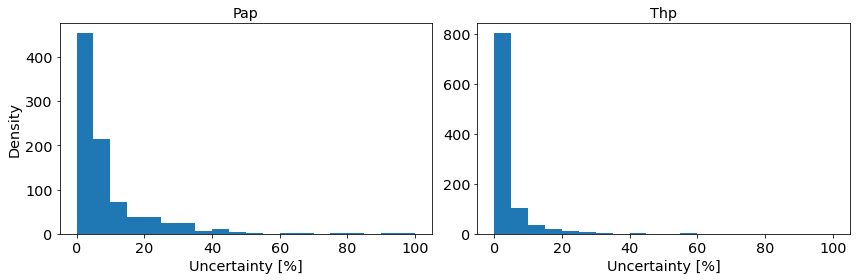

min, average and max measurement uncertainty for Pap [%]: 0.37 10.17 500.0
min, average and max measurement uncertainty for Thp [%]: 0.11 4.12 147.95
For Pap:  50.4 % of measurements has uncertainty of < 5%;  23.9 % has uncertainty of 5-10%;
For Thp:  80.3 % of measurements has uncertainty of < 5%;  10.4 % has uncertainty of 5-10%;


<Figure size 432x288 with 0 Axes>

In [86]:
# investigate measurement uncertainties
nr_bins = 20

Pap_uncertainty_percentage = (obs_p.Pap_err / obs_p.Pap * 100).dropna(how='all')
Thp_uncertainty_percentage = (obs_p.Thp_err / obs_p.Thp * 100).dropna(how='all')

## plot
fig, ax = plt.subplots(1,2, figsize=(12,4))

obj = Pap_uncertainty_percentage.values
n,bins,patches = ax[0].hist(obj, bins=nr_bins, range=(0,100))
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Uncertainty [%]')
ax[0].set_title('Pap')

obj = Thp_uncertainty_percentage.values
n,bins,patches = ax[1].hist(obj, bins=nr_bins, range=(0,100))
ax[1].set_xlabel('Uncertainty [%]')
ax[1].set_title('Thp')

plt.tight_layout()
plt.show()
plt.savefig(savedir / 'uncertainty_particulate_geotraces.pdf')

## print info
print('min, average and max measurement uncertainty for Pap [%]:', np.round(Pap_uncertainty_percentage.min(),2), 
      np.round(Pap_uncertainty_percentage.mean(),2), np.round(Pap_uncertainty_percentage.max(),2))
print('min, average and max measurement uncertainty for Thp [%]:', np.round(Thp_uncertainty_percentage.min(),2), 
      np.round(Thp_uncertainty_percentage.mean(),2), np.round(Thp_uncertainty_percentage.max(),2))

# only use this figure for the bins info
fig, ax = plt.subplots(1)
obj = Pap_uncertainty_percentage.values
n,bins,patches = ax.hist(obj, bins=20, range=(0,100))
print('For Pap: ', np.round(n[0]/len(obj)*100,1), '% of measurements has uncertainty of < 5%; ', np.round(n[1]/len(obj)*100,1), '% has uncertainty of 5-10%;')
obj = Thp_uncertainty_percentage.values
n,bins,patches = ax.hist(obj, bins=20, range=(0,100))
print('For Thp: ', np.round(n[0]/len(obj)*100,1), '% of measurements has uncertainty of < 5%; ', np.round(n[1]/len(obj)*100,1), '% has uncertainty of 5-10%;')
plt.close()

### Count number of seawater data points for particle-bound
Is only geotraces

In [21]:
print('number of stations; number of measurements; average uncertainties:\n')

this_obs_label = ['geotraces excl arctic = ALL']
for i,this_obs in enumerate([obs_p]):
    print(this_obs_label[i])
    
    # Pap
    avg_unc = ( this_obs.Pap_err / this_obs.Pap ).mean() * 100  # in %
    this_obs_Pap = this_obs.Pap.dropna(how='all')
    nr_stations = this_obs_Pap.reset_index().loc[:,('lon','lat')].drop_duplicates().shape[0]
    nr_meas = this_obs_Pap.shape[0]
    print('Pap:', nr_stations, nr_meas, np.round(avg_unc,2),'%')

    # Thp
    avg_unc = ( this_obs.Thp_err / this_obs.Thp ).mean() * 100  # in %
    this_obs_Thp = this_obs.Thp.dropna(how='all')
    nr_stations = this_obs_Thp.reset_index().loc[:,('lon','lat')].drop_duplicates().shape[0]
    nr_meas = this_obs_Thp.shape[0]
    print('Thp:', nr_stations, nr_meas, np.round(avg_unc,2),'%')
    
    print('\n')

number of stations; number of measurements; average uncertainties:

geotraces excl arctic = ALL
Pap: 50 548 10.67 %
Thp: 59 648 4.89 %




<a id='load-model'></a>
# Load model runs - quick  
Here we only load the run IDs (which determine the runnames) and the parameters.  
It is combined into a table, to which we later add the RMSEs and final skill scores per run.  
We do not need to load the model runs here, but this is done 1 by 1 in the part 'Compute RMSE'.  
[go to top](#top)

### Load run IDs and parameters

In [12]:
# read in the csv on which the tuning runs were based
# this already gives us columns run_ID and the 13 parameters that were adjusted (all in the BGC routine, of which Pa, Th is a part)
# using var 'ensemble' as set on top of this notebook
total_table = pd.read_csv(obsdir / ('parameters_'+ensemble+'_sampled_after_constraints.csv'))

total_table.rename(columns={'# setID':'run_ID', '﻿BGC_PaThWs':'PaThWs', 'BGC_PaDesConst':'PaDesConst', 'BGC_PaThWs':'PaThWs', 'BGC_ThDesConst':'ThDesConst', 
                            'BGC_sigmaPaPOC':'sigmaPaPOC', 'BGC_sigmaPaCa':'sigmaPaCa', 
                            'BGC_sigmaPaOp':'sigmaPaOp', 'BGC_sigmaPaDu':'sigmaPaDu', 'BGC_sigmaPaNeph':'sigmaPaNeph', 
                            'BGC_sigmaThPOC':'sigmaThPOC', 'BGC_sigmaThCa':'sigmaThCa', 
                            'BGC_sigmaThOp':'sigmaThOp', 'BGC_sigmaThDu':'sigmaThDu', 'BGC_sigmaThNeph':'sigmaThNeph'}, 
                   inplace=True) # BGC_PaThWs column name contained still DOF unicode char

# add a column with the runname for completeness (corresponding parameter files, .out files and output files carry this name)
#     N.B. technically speaking: with runname we mean parameterfilesname here. We dont mean executablename, 
#     since the executable is the same for the entire ensemble.
total_table.insert(1, 'runname', [f.runname(n, ID=True, ensemble=ensemble) for n in total_table.run_ID]) # add new column runnames after column 1

<a id='explore-model'></a>
# Explore model runs
Ca. 3000 model runs are done for the tuning. Here we explore them and do a couple of checks to see that they were succesfull and are in equilibrium at the end.  
Runnames have the form '1TUNNNN_PI' or '2TUNNNN_PI', where:
- '1TU' is the ensemble name and stands for tuning 1   
  '2TU' is tuning ensemble 2 (optionally a 3rd step could be taken in a subdomain of the parameter space to zoom in more)  
  Notebook runs the ensemble that is set on the very top of the notebook.  
- 'NNNN' is the run ID, **going from 1000 to 3950 for 1TU; from 1000 to 1510 for 2TU**
- '_ PI' is the phase name, but we only have 1 phase (no separate spinups are needed if params change), at pre-industrial steady state.   

All model runnames with their parameters are already load into a table 'table_total' above.
  
[go to top](#top)

### Plot parameter distributions as scatter as a check
They are uniformly distributed (for 2TU), except for the check conditions, which change mainly du's and neph's distribution.

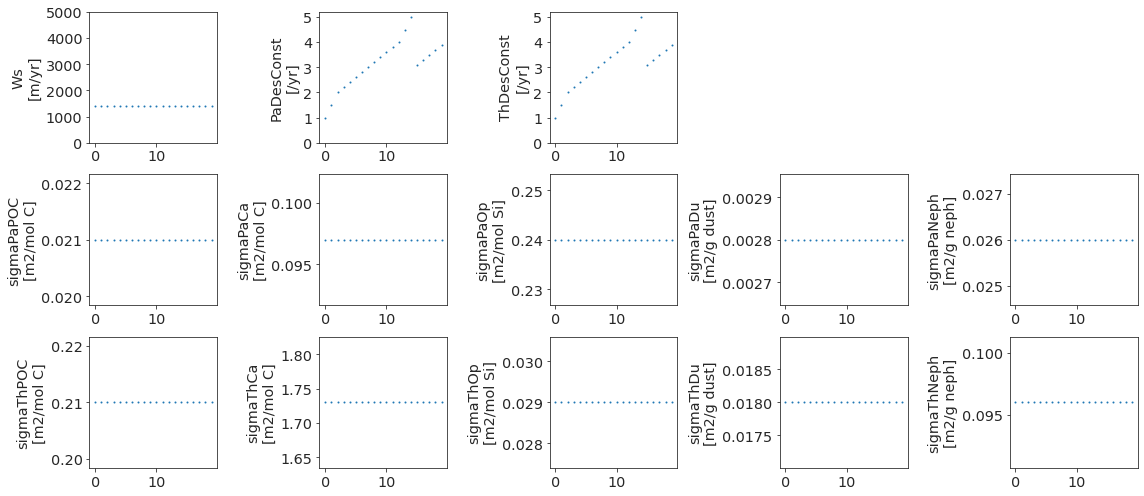

In [19]:
fig, ax = plt.subplots(3,5, figsize=(16,7))

x = total_table.index
ax[0,0].scatter(x, total_table.PaThWs, s=1)
ax[0,0].set_ylabel('Ws\n[m/yr]')
ax[0,0].set_yticks(range(0,5500,1000))

ax[0,1].scatter(x, total_table.PaDesConst, s=1)
ax[0,1].set_ylabel('PaDesConst\n[/yr]')
ax[0,1].set_yticks(range(0,6))
ax[0,2].scatter(x, total_table.ThDesConst, s=1)
ax[0,2].set_ylabel('ThDesConst\n[/yr]')
ax[0,2].set_yticks(range(0,6))

ax[1,0].scatter(x, total_table.sigmaPaPOC, s=1)
ax[1,0].set_ylabel('sigmaPaPOC\n[m2/mol C]')
ax[2,0].scatter(x, total_table.sigmaThPOC, s=1)
ax[2,0].set_ylabel('sigmaThPOC\n[m2/mol C]')

ax[1,1].scatter(x, total_table.sigmaPaCa, s=1)
ax[1,1].set_ylabel('sigmaPaCa\n[m2/mol C]')
ax[2,1].scatter(x, total_table.sigmaThCa, s=1)
ax[2,1].set_ylabel('sigmaThCa\n[m2/mol C]')

ax[1,2].scatter(x, total_table.sigmaPaOp, s=1)
ax[1,2].set_ylabel('sigmaPaOp\n[m2/mol Si]')
ax[2,2].scatter(x, total_table.sigmaThOp, s=1)
ax[2,2].set_ylabel('sigmaThOp\n[m2/mol Si]')

ax[1,3].scatter(x, total_table.sigmaPaDu, s=1)
ax[1,3].set_ylabel('sigmaPaDu\n[m2/g dust]')
ax[2,3].scatter(x, total_table.sigmaThDu, s=1)
ax[2,3].set_ylabel('sigmaThDu\n[m2/g dust]')

ax[1,4].scatter(x, total_table.sigmaPaNeph, s=1)
ax[1,4].set_ylabel('sigmaPaNeph\n[m2/g neph]')
ax[2,4].scatter(x, total_table.sigmaThNeph, s=1)
ax[2,4].set_ylabel('sigmaThNeph\n[m2/g neph]')

ax[0,3].set_axis_off()
ax[0,4].set_axis_off()

plt.tight_layout()
plt.savefig(savedir / ('params_ensemble_' + ensemble + '.pdf'))

Now we load all runs. To save memory, we take care to only load the relevant variables, such that the memory is much less and this is actually possible. Runs are already such that full output was saved only for the last time step.  
Estimate: loading only Pad and Thd from the in total ca. 75 three-dimensional vars, will load ca. 2/75 of the full_ave.nc output files. These files are each 18 Mb (1 file per run), so instead of 54 Gb, **we will load ca. 1.4 Gb into memory.**  
For ensemble 2TU everything looks uniform indeed except Du and Neph, because of the constraints that a.o. Du > Neph

### Check that no runs produced nan output everywhere

In [20]:
# ================= TAKES A WHILE (< 5 MIN)========================

# LOAD FULL MODEL OUTPUT OF ALL RUNS FOR Pa,Th VARS ONLY

###### SETTINGS #########################
runs = [f.runname(n, ensemble=ensemble) for n in all_run_nrs[ensemble]]
# runs = [f.runname(n, ensemble=ensemble) for n in all_run_nrs[ensemble][0:10]]  # for testing
#########################################

modelled_path_vars = f.load_var_multiple_runs(['Pad','Thd','Pap','Thp'], 'full_ave', 
                                              modeldir, runs, spinup_yr=spinup_yr)

## CHECK THAT ALL RUNS WERE SUCCESFULL (no only-NaN output)
## => print if any run has NaN values in Pad and Thd at example ocean grid cell
for run in runs:
    if np.isnan(modelled_path_vars[run].Pad.isel(lon_t=10, lat_t=10, z_t=10, time=-1).item()):
        print("Nan values for Pad in run ", run)
    if np.isnan(modelled_path_vars[run].Thd.isel(lon_t=10, lat_t=10, z_t=10, time=-1).item()):
        print("Nan values for Thd in run ", run)
    if np.isnan(modelled_path_vars[run].Pap.isel(lon_t=10, lat_t=10, z_t=10, time=-1).item()):
        print("Nan values for Pad in run ", run)
    if np.isnan(modelled_path_vars[run].Thp.isel(lon_t=10, lat_t=10, z_t=10, time=-1).item()):
        print("Nan values for Thd in run ", run)

print('All',len(runs),'runs were succesfull IF this is the first print statement. Done.')

All 20 runs were succesfull IF this is the first print statement. Done.


In [21]:
# delete object again to save memory
del modelled_path_vars

### Inventory
not used yet but can be interesting

run: KDE1002_PI


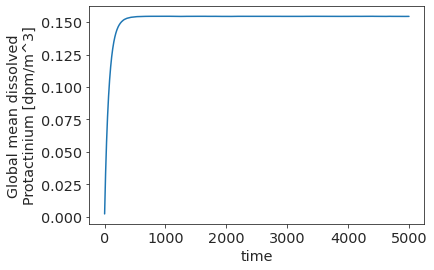

In [22]:
# ================= TAKES A WHILE (< 5 MIN)========================

# Inventory over time; should approach equilibrium
n = 2   # run number
print('run:', f.runname(all_run_nrs[ensemble][n], ensemble=ensemble))

modelled_inventory = f.load_var_multiple_runs(['tinv_Pad','tinv_Thd','tinv_Pap','tinv_Thp'], 
                                              'timeseries_inst', modeldir, runs, spinup_yr=spinup_yr)
modelled_inventory[f.runname(all_run_nrs[ensemble][n], ensemble=ensemble)].tinv_Pad.plot()
plt.show()
# example plot of inventory for first run and Pad

In [23]:
# delete objects again to save memory
del modelled_inventory

<a id='MRT'></a>
# Compute Mean Residence Time (MRT)
Saved MRT is based on average of last 50 years of run. Also checks that in equilibrium: otherwise MRT=nan is added to total_table.  

**Expected residence time:**   
Marchal et al. 2000 & Siddall et al. 2005 cite Yu et al. 1996: Pa ~200 yr; Th ~30yr  
Rempfer et al. 2017 (cites multiple): Pa 100-200 yr; Th few decades  
**Missiaen et al. 2020 (cites Henderson et al. 2003): Pa 50-200 yr; Th 10-40 yr**  
[go to top](#top)

In [13]:
# ================= TAKES A WHILE (< 5 MIN)========================

## Load MEAN RESIDENCE TIME for all runs
runs = [f.runname(n, ensemble=ensemble) for n in all_run_nrs[ensemble]]
modelled_mrt = f.load_var_multiple_runs(['Mrt_Pa_bac','Mrt_Th_bac'], 
                                        'timeseries_inst', modeldir, runs, spinup_yr=spinup_yr)
sec_to_yr = 1.0 / (365.25*24*3600)

equilibrium residence time of Pa: 67.7 yr
equilibrium residence time of Th: 18.3 yr



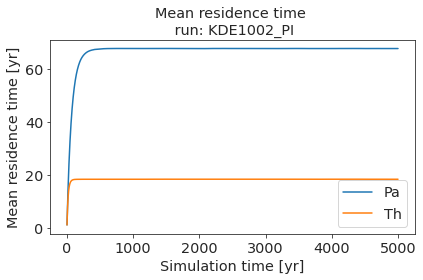

In [14]:
# PLOT mean residence time for a specific run

######### SETTINGS ############### 
n = 2  # run number of ensemble
##################################

ds = modelled_mrt[f.runname(all_run_nrs[ensemble][n], ensemble=ensemble)]

sns.set_style('ticks')
fig, ax = plt.subplots(1)

ax.set_title('Mean residence time \n run: ' + f.runname(all_run_nrs[ensemble][n], ensemble=ensemble))
ax.plot(ds.Mrt_Pa_bac.time, ds.Mrt_Pa_bac * sec_to_yr, label='Pa')
ax.plot(ds.Mrt_Th_bac.time, ds.Mrt_Th_bac * sec_to_yr, label='Th')
ax.legend(loc='lower right')
ax.set_xlabel('Simulation time [yr]')
ax.set_ylabel('Mean residence time [yr]')
plt.tight_layout()
plt.savefig(savedir / ('residence_time_run_' + f.runname(all_run_nrs[ensemble][n], ensemble=ensemble) + '.pdf'))

# diagnose residence time at last 100 years
print('equilibrium residence time of Pa:', np.round((ds.Mrt_Pa_bac[-100:-1] * sec_to_yr).mean().item(),1), 'yr')
print('equilibrium residence time of Th:', np.round((ds.Mrt_Th_bac[-100:-1] * sec_to_yr).mean().item(),1), 'yr\n')

In [15]:
# ================= TAKES A WHILE (< 5 MIN)========================

## check if runs are in equilibrium & insert MRT to table

###### SETTINGS #########################
# what is the 'internal variability' of the above curve? (trial and error by eye gives 0.1 yr)
delta_significant = 0.1  # in yr; a difference is significant if > delta_significant
# hardcoded: 50 yr average of MRT at end is saved
#########################################

# fill lists with information on the way
mrts_Pa = []
mrts_Th = []
for n in all_run_nrs[ensemble]:
    ds = modelled_mrt[f.runname(n, ensemble=ensemble)]
    # t1 is 200 yr before end;     t2 is at end (50 yr average)
    mrt_Pa_t1 = ds.Mrt_Pa_bac.isel(time=-200) * sec_to_yr                    
    mrt_Pa_t2 = ds.Mrt_Pa_bac.isel(time=slice(-50,-1)).mean() * sec_to_yr 
    mrt_Th_t1 = ds.Mrt_Th_bac.isel(time=-200) * sec_to_yr 
    mrt_Th_t2 = ds.Mrt_Th_bac.isel(time=slice(-50,-1)).mean() * sec_to_yr   

    if abs(mrt_Pa_t2 - mrt_Pa_t1) < delta_significant:
        # simulation ran into equilibrium
        mrts_Pa.append(mrt_Pa_t2.item())
        mrts_Th.append(mrt_Th_t2.item())
    else:
        # mrts_Pa.append(mrt_Pa_t2)
        # mrts_Th.append(mrt_Th_t2)
        # save nan instead as a sign that this run is not in equilibrium
        mrts_Pa.append(np.nan)
        mrts_Th.append(np.nan)        
        print("MRT is not constant i.e. no equilibrium for run nr", n, "which has runname", f.runname(n,ensemble=ensemble))
        
print('All',len(all_run_nrs[ensemble]),'runs were succesfull IF this is the first print statement. Done.')
# surprisingly, all runs of 2TU are in equilibrium!

# add resulting MRTs to table
total_table.insert(2, 'MRT_Pa', mrts_Pa) # add new column MRT_Pa after column 2
total_table.insert(3, 'MRT_Th', mrts_Th) 

All 84 runs were succesfull IF this is the first print statement. Done.


In [16]:
# explore result
print('min and max MRT of Pa:', round(np.nanmin(mrts_Pa),1), round(np.nanmax(mrts_Pa),1), 'yr')    # wanted 50-200
print('min and max MRT of Th:', round(np.nanmin(mrts_Th),1), round(np.nanmax(mrts_Th),1), 'yr \n') # wanted 10-40

min and max MRT of Pa: 42.3 144.1 yr
min and max MRT of Th: 10.6 35.2 yr 



- Ensemble 1TU: residence times are way too low!
- Ensemble 2TU: residence times have the correct range inside them (but span more)
- Ensemble PAR: residence times for Pa are perfect funnily enough; for Th have the correct range inside them (but span more)
- Ensemble 3TU: residence times have the correct range inside them (but span more)

In [17]:
## delete objects again to save memory
del modelled_mrt

<a id='median-kads'></a>
# Compute median ( and k_ads_Pa_sum, k_ads_Th_sum (a measure of total scavenging) )
[go to top](#top)  

### We compute K_ads^j_summed as a measure of total scavenging, to sort model ensemble
Why?   
I expect that total scavenging dominates over individual params. (Rempfer et al. ONLY tuned the total scavenging sigma_0). If my suspicion is correct, only tuning runs with comparable K_ads^j_summed should be compared.  

Here the sum is over all grid cells, weighted by the grid cell volume (IS A CHOICE):
$$\sum_{\theta,\phi,z} k_{ads}^{Pa} (\theta,\phi,z) = 
\frac{\sum_{\theta,\phi,z} \sum_i V(\theta,\phi,z) \cdot \sigma_i^{Pa} \cdot F_i(\theta,\phi,z)}{\sum_{\theta,\phi,z} V(\theta,\phi,z)}
$$  
where land and sediment cells are ignored and the particle flux is the export flux multiplied with the remineralization profile for particle type $i$:  
$$F_i(\theta,\phi,z) = F_{i,surf}(\theta,\phi)\cdot R_i(z)$$  
Analagously for Th.

In [18]:
############################################# TAKES CA. 5 MINS ########

# COMPUTE median & K_ads_Pa_summed & K_ads_Th_summed AND ADD TO TABLE

######### SETTINGS: ########
# run_nrs = [334, 297, 15] # for testing 2TU; 334, 297, 15 are best fits (wo Arctic): overall, for Pad, for Thd
# run_nrs = all_run_nrs[ensemble][0:5]
run_nrs = all_run_nrs[ensemble]    # defined at top of notebook
############################

## ASSUMING PARTICLE EXPORT FIELDS ARE THE SAME FOR ALL RUNS

# print observations median of Pad, Thd, Pap, Thp as comparison
print('median of Pad obs:', obs_d.Pad.median(), 'uBq/kg')
print('median of Thd obs:', obs_d.Thd.median(), 'uBq/kg')
if 'obs_p' in globals():
    print('median of Pap obs:', obs_p.Pap.median(), 'uBq/kg')
    print('median of Thp obs:', obs_p.Thp.median(), 'uBq/kg\n')

## load all model data
runnames = [f.runname(nr=i, ensemble=ensemble, ID=False) for i in run_nrs]
load_vars = ['Pad','Thd','Pap','Thp','rho_SI','boxvol']
# load_vars = ['Pad','Thd','Pap','Thp','FLDPOM','FLDCA','FLDOP','rho_SI','boxvol']
data_fulls = f.load_var_multiple_runs(variables=load_vars, file_type='full_ave', 
                                      folder=modeldir, runs=runnames)  # still has model units of dpm/m3; converted below

# COMMENT OUT KADSTOTAL

# ## prepare dust field for K_ads dust term
# # outside loop over runs because always the same
# # read in dust field (based on Mahowald et al., 2006, JGR)
# bgc_input_fields = xr.open_dataset(obsdir / 'world_41x40.BGC.nc', decode_times=False)
# dust_field = bgc_input_fields.dust_dep_mod.mean(dim='time') * 1000 # avg over 12 months; result in g-dust/m**2/s
# # process same way as in model: conversion of dust-units; kg-dust/m^2/s to g-dust/m**2/s                                                                                                                                                   
# flux_du = dust_field * 365.25 * 24 * 3600

# ## prepare sigma values
# sigmas_all_runs = total_table.loc[:,('run_ID','sigmaPaPOC', 'sigmaPaCa', 'sigmaPaOp', 'sigmaPaDu', 
#                                      'sigmaThPOC', 'sigmaThCa', 'sigmaThOp', 'sigmaThDu')]

# ## prepare fluxes F_i
# # ASSUMING PARTICLE EXPORT FIELDS ARE THE SAME FOR ALL RUNS; otherwise move inside for loop
n = run_nrs[0]
run = f.runname(nr=n, ensemble=ensemble, ID=False)
# # Find export fluxes F_i(theta,phi) at surface
# # output is in C/(m^2*s) resp. C/(m^2*s) resp. Si/(m^2*s) resp. g dust/(m^2*s) 
# # but convert /s to /yr:
# flux_poc = data_fulls[run]['FLDPOM'].isel(time=-1) * 365.25 * 24 * 3600 
# flux_ca = data_fulls[run]['FLDCA'].isel(time=-1) * 365.25 * 24 * 3600
# flux_op = data_fulls[run]['FLDOP'].isel(time=-1) * 365.25 * 24 * 3600

# prepare grid cell volume and mask it with wet cells only
# used for k_ads_sum
vol = data_fulls[run].boxvol  
test_var = data_fulls[run].Pad.isel(time=-1)
vol = xr.where(np.isnan(test_var), np.nan, vol)
# correct: since vol is in denum and nom, this mask is applied to both sums over theta,phi,z

## loop over runs and fill information on the way
median_Pad = []
median_Thd = []
median_Pap = []
median_Thp = []
# k_ads_pa_sum = []
# k_ads_th_sum = []
for i,n in enumerate(run_nrs):
    run = f.runname(nr=n, ensemble=ensemble, ID=False)
    
    # convert model units dpm/m3 to uBq/kg
    obj = data_fulls[run].isel(time=-1) # output of this run, still in dpm/m3
    obj = f.model_to_sw_unit(obj, data_fulls[run].rho_SI.isel(time=-1)) # to uBq/kg

    # compute and save median
    median_Pad.append(obj.Pad.median().item())
    median_Thd.append(obj.Thd.median().item())
    median_Pap.append(obj.Pap.median().item())
    median_Thp.append(obj.Thp.median().item())
    
#     ## Compute and save K_ads^j_summed, where sum is over all grid cells
#     # TODO ignoring direct effect of neph on Kads for now (indirect: other diffusion is w/i run)

#     # Find sigmas of this run nr n
#     if ensemble == 'PAR':
#         # quick fix with using i instead of n (n is a string in case of PAR ensemble); breaks if specific run nrs are asked
#         [junk_ID, sig_pa_poc, sig_pa_ca, sig_pa_op, sig_pa_du, 
#          sig_th_poc, sig_th_ca, sig_th_op, sig_th_du] = sigmas_all_runs.loc[i].values
#     else:
#         # [sig_pa_poc, sig_pa_ca, sig_pa_op, sig_pa_du, 
#         #  sig_th_poc, sig_th_ca, sig_th_op, sig_th_du] = sigmas_all_runs.loc[n].values
        
#         [junk_ID, sig_pa_poc, sig_pa_ca, sig_pa_op, sig_pa_du, 
#          sig_th_poc, sig_th_ca, sig_th_op, sig_th_du] = sigmas_all_runs[sigmas_all_runs.run_ID == n+1000].values[0]
    
#     # Compute k_ads_sum
#     this_kads_pa_sum = 0  # unit is /yr, same as k_ads_pa
#     this_kads_th_sum = 0
#     for z in data_fulls[run].z_t:
#         # vol.sel(z_t=z) & flux_poc both have coords (lat,lon), which are preserved; rest scalars
#         res = vol.sel(z_t=z) * (flux_poc * sig_pa_poc * f.remin_curve_val(z, 'POC') +
#                                 flux_ca * sig_pa_ca * f.remin_curve_val(z, 'CaCO3') +
#                                 flux_op * sig_pa_op * f.remin_curve_val(z, 'opal') +
#                                 flux_du * sig_pa_du * f.remin_curve_val(z, 'dust') ) # numerator (theta,phi,z)
#         this_kads_pa_sum += res.sum(dim=('lat_t','lon_t')).item()

#         # repeat for Th
#         res = vol.sel(z_t=z) * (flux_poc * sig_th_poc * f.remin_curve_val(z, 'POC') +
#                                 flux_ca * sig_th_ca * f.remin_curve_val(z, 'CaCO3') +
#                                 flux_op * sig_th_op * f.remin_curve_val(z, 'opal') +
#                                 flux_du * sig_th_du * f.remin_curve_val(z, 'dust') ) 
#         this_kads_th_sum += res.sum(dim=('lat_t','lon_t')).item()
#     # denominator: divide by total weights
#     k_ads_pa_sum.append(this_kads_pa_sum / vol.sum().item())
#     k_ads_th_sum.append(this_kads_th_sum / vol.sum().item())
    
    # print result for 1 run
    if run == '2TU1334_PI':
        print('median of Pad best-fit (run nr 334):', obj.Pad.median().item(), 'uBq/kg')
        print('median of Thd best-fit (run nr 334):', obj.Thd.median().item(), 'uBq/kg')
        print('median of Pap best-fit (run nr 334):', obj.Pap.median().item(), 'uBq/kg')
        print('median of Thp best-fit (run nr 334):', obj.Thp.median().item(), 'uBq/kg\n')
        
        # print('k_ads_pa_sum of best-fit (run nr 334):', this_kads_pa_sum, '/yr')
        # print('k_ads_th_sum of best-fit (run nr 334):', this_kads_th_sum, '/yr\n')

# add results to table
total_table.insert(4, 'median_Pad', median_Pad)
total_table.insert(5, 'median_Thd', median_Thd)
total_table.insert(6, 'median_Pap', median_Pap)
total_table.insert(7, 'median_Thp', median_Thp)
# total_table.insert(8, 'k_ads_pa_sum', k_ads_pa_sum)
# total_table.insert(9, 'k_ads_th_sum', k_ads_th_sum)

# delete (large) datasets again to save memory
del data_fulls

median of Pad obs: 2.592 uBq/kg
median of Thd obs: 4.737377 uBq/kg
median of Pap obs: 0.030676 uBq/kg
median of Thp obs: 0.5572295 uBq/kg



<a id='RMSE'></a>
# Compute RMSEs
We will now use obs_ave together with every model run via the get_sim() function to compute RMSE of model-obs misfit. Care is taken that both objects are pandas dataframes (both xarray would have been possible as well but not implemented).    
Weights: obs uncertainties & grid cell volume  
[go to top](#top)

In [158]:
## prepare: load obs 

## load observations again to be sure to have the right version / desired subset

# dissolved
# load geotraces observations
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')
obs_d_incl_arctic = pd.concat([obs_d_geotraces_incl_arctic,obs_d_deng,obs_d_ng
                               ,obs_d_pavia], join='outer')  # for completeness; not used
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)

# particle-bound
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)

<ipython-input-158-4f9e1c643f82>:8: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE',


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


In [ ]:
## prepare: compute weights

# load one example run; only used for volume of grid cells
if ensemble == 'PAR':
    runid = all_run_nrs[ensemble][0]
else:
    runid = all_run_nrs[ensemble][0] + 1000  # must be ID
    
# dissolved
[res_d_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
# find weights (explained below) => 3 types possible
[weights_tot_Pad, weights_tot_Thd] = f.find_weights(obs_d_ave, res_entire, volume=True, uncertainty=True)
[weights_vol_Pad, weights_vol_Thd] = f.find_weights(obs_d_ave, res_entire, volume=True, uncertainty=False)
[weights_unc_Pad, weights_unc_Thd] = f.find_weights(obs_d_ave, res_entire, volume=False, uncertainty=True)

# particle-bound 
# => has other res_table since obs are at other locations: other model grid cells are selected
[res_p_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_p_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
# find weights (explained below) => 3 types possible
[weights_tot_Pap, weights_tot_Thp] = f.find_weights(obs_p_ave, res_entire, volume=True, uncertainty=True)
[weights_vol_Pap, weights_vol_Thp] = f.find_weights(obs_p_ave, res_entire, volume=True, uncertainty=False)
[weights_unc_Pap, weights_unc_Thp] = f.find_weights(obs_p_ave, res_entire, volume=False, uncertainty=True)

### Set weights
- We choose the RMSE as measure of the observation minus model misfit (not e.g. MSE) because it is easier interpretable as the unit of RMSE is the same as the unit of obs/models.   
Formula:  
$$RMSE = \sqrt{\frac{\sum_{k=1}^N w_k \cdot (sim_k - obs_k)^2}{\sum_{k=1}^N w_k}}$$
where $k$ is a model grid cell (lat, lon, z) where observations are present. If multiple observations occur in 1 grid cell, they are averaged and the result is saved as $obs_k$. Output of model grid cells where no observations are present is ignored.
- We want to weight the RMSE by the uncertainty in the observations. If this was our only weighting, we would choose weights
$$w_{err,k} = \frac{1}{err_k}$$
where $err_k$ is the uncertainty reported in the observations. Note that $w_k \to \infty$ when $err_k\to 0$, but we check below that none of the errors in Pad and Thd is literally 0. 
- We also want to weight the RMSE by the grid cell volume. This is important because we are not interested in the surface, but most observations are in the surface ocean. In our model, grid box height increases exponentially with depth, so deeper cells will have more weight. If this was our only weighting, the weights would be
$$w_{vol,k} = vol_k$$   
where $vol_k$ is the grid cell volume in $m^3$.
- Now we combine both types of weights to
$$w_k = \frac{vol_k}{err_k}$$
- This last formula is used in the function find_weights()

### Get RMSE for 1 example run

In [28]:
# first load 1 model run

###### SETTINGS #########################
n = 5  # set run_nr
#########################################

if ensemble == 'PAR':
    runid = all_run_nrs[ensemble][n]
else:
    runid = all_run_nrs[ensemble][n] + 1000  # must be ID
    
[res_d_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
[res_p_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_p_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
# res_entire gives entire model data in xarray(all 3D variables including also Pad, Thd, Pap, Thp)
# res_d/p_table gives pandas dataframe/table with columns Pad,Thd resp. Pap,Thp; only containing grid cells where obs are 
#               available; using index of obs_ave (column names of obs_ave determine whether Pad,Thd or Pap,Thp is of interest)

In [29]:
# compute RMSE for that example run without weights
print('RMSEs without weights for runid', runid,':')
print('Pad:')
this_RMSE = f.calc_rmse(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=None, verbose=True)
print('Thd:')
this_RMSE = f.calc_rmse(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=None, verbose=True)
print('Pap:')
this_RMSE = f.calc_rmse(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=None, verbose=True)
print('Thp:')
this_RMSE = f.calc_rmse(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=None, verbose=True)
print('\n')

# now with total weights (grid volume and observational uncertainty)
print('RMSEs with total weights for runid', runid,':')
print('Pad:')
this_RMSE = f.calc_rmse(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_tot_Pad, verbose=True)
print('Thd:')
this_RMSE = f.calc_rmse(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_tot_Thd, verbose=True)
print('Pap:')
this_RMSE = f.calc_rmse(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_tot_Pap, verbose=True)
print('Thp:')
this_RMSE = f.calc_rmse(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_tot_Thp, verbose=True)

print('RMSEs with volume weights for runid', runid,':')
print('Pad:')
this_RMSE = f.calc_rmse(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_vol_Pad, verbose=True)
print('Thd:')
this_RMSE = f.calc_rmse(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_vol_Thd, verbose=True)
print('Pap:')
this_RMSE = f.calc_rmse(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_vol_Pap, verbose=True)
print('Thp:')
this_RMSE = f.calc_rmse(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_vol_Thp, verbose=True)

print('RMSEs with uncertainty weights for runid', runid,':')
print('Pad:')
this_RMSE = f.calc_rmse(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_unc_Pad, verbose=True)
print('Thd:')
this_RMSE = f.calc_rmse(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_unc_Thd, verbose=True)
print('Pap:')
this_RMSE = f.calc_rmse(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_unc_Pap, verbose=True)
print('Thp:')
this_RMSE = f.calc_rmse(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_unc_Thp, verbose=True)


RMSEs without weights for runid 1005 :
Pad:
RMSE = 2.215 [uBq/kg]
Thd:
RMSE = 7.358 [uBq/kg]
Pap:
RMSE = 0.115 [uBq/kg]
Thp:
RMSE = 2.97 [uBq/kg]


RMSEs with total weights for runid 1005 :
Pad:
RMSE = 1.99 [uBq/kg]
Thd:
RMSE = 5.556 [uBq/kg]
Pap:
RMSE = 0.049 [uBq/kg]
Thp:
RMSE = 0.793 [uBq/kg]
RMSEs with volume weights for runid 1005 :
Pad:
RMSE = 2.166 [uBq/kg]
Thd:
RMSE = 5.956 [uBq/kg]
Pap:
RMSE = 0.078 [uBq/kg]
Thp:
RMSE = 2.296 [uBq/kg]
RMSEs with uncertainty weights for runid 1005 :
Pad:
RMSE = 1.631 [uBq/kg]
Thd:
RMSE = 6.939 [uBq/kg]
Pap:
RMSE = 0.033 [uBq/kg]
Thp:
RMSE = 0.514 [uBq/kg]


In [23]:
print('Average obs Pad is', np.round(obs_d_ave.Pad.mean(),2), 'uBq/kg,   with an average uncertainty of ', 
      np.round(obs_d_ave.Pad_err.mean(),3), 'uBq/kg, which is ', 
      np.round(obs_d_ave.Pad_err.mean() / obs_d_ave.Pad.mean() * 100,1),'%.')
print('Average obs Thd is', np.round(obs_d_ave.Thd.mean(),2), 'uBq/kg,   with an average uncertainty of ', 
      np.round(obs_d_ave.Thd_err.mean(),3), 'uBq/kg, which is ', 
      np.round(obs_d_ave.Thd_err.mean() / obs_d_ave.Thd.mean() * 100,1),'%.')
print('Average obs Pap is', np.round(obs_p_ave.Pap.mean(),2), 'uBq/kg,   with an average uncertainty of ', 
      np.round(obs_p_ave.Pap_err.mean(),3), 'uBq/kg, which is ', 
      np.round(obs_p_ave.Pap_err.mean() / obs_p_ave.Pap.mean() * 100,1),'%.')
print('Average obs Thp is', np.round(obs_p_ave.Thp.mean(),2), 'uBq/kg,   with an average uncertainty of ', 
      np.round(obs_p_ave.Thp_err.mean(),3), 'uBq/kg, which is ', 
      np.round(obs_p_ave.Thp_err.mean() / obs_p_ave.Thp.mean() * 100,1),'%.')
# => obs uncertainties in percentage domain => non-negligible: using them as weights is meaningful.

Average obs Pad is 3.11 uBq/kg,   with an average uncertainty of  0.135 uBq/kg, which is  4.4 %.
Average obs Thd is 6.7 uBq/kg,   with an average uncertainty of  0.167 uBq/kg, which is  2.5 %.
Average obs Pap is 0.06 uBq/kg,   with an average uncertainty of  0.003 uBq/kg, which is  5.0 %.
Average obs Thp is 1.12 uBq/kg,   with an average uncertainty of  0.024 uBq/kg, which is  2.1 %.


## Get all RMSEs
[go to top](#top)

In [12]:
## define basins/cruises of interest
# using obs_d since obs_p would only give a subset of that
cruises_incl_arctic = np.unique(obs_d_incl_arctic.cruise)  # for completion; not used
cruises_all = np.unique(obs_d.cruise)                      # already excludes Arctic cruises

# only 1 basin incl its SO sector
cruises_Atl = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10','GIPY04', 'GIPY05', 
               'deng', 'ng'] # deng=geovide
cruises_Pac = ['GP16', 'GPc01', 'GSc02', 'pavia']

# SO (Southern Ocean)
cruises_SO = ['GSc02','GIPY04', 'GIPY05','GIpr05', 'pavia'] 
# chosing here the definition that GA10 is not SO

# for testing purposes; NOTE: these are only in the obs_d_incl_arctic, obs_p_incl_arctic objects
cruises_Arctic = ['GN01', 'GN02', 'GN03', 'GN04']  
cruises_Labr = ['GN02']

## Get all desired RMSEs: per basin & with/without surface & with/without weights

In [22]:
######### COMPUTE ALL DESIRED RMSEs: TAKES A LONG WHILE ###########
                            # for 150 runs x 16 tasks x 2 (Pad,Thd) = 4800 it took 30 minutes so ca. 0.4 second per RMSE per run
                            # but really depends on overhead of loading observations again for each task
###### SETTINGS ######

# define all RMSEs to be computed as fourplets and name them (without the _Pad, _Thd)
# fourplets (cruises, wo_surface, weighted_vol, weighted_unc) 

RMSE_tasks = {'RMSE_unc_weights':(cruises_all,False,False,True), 
              'RMSE_no_weights':(cruises_all,False,False,False),
              'RMSE_incl_arctic_unc_weights':(cruises_incl_arctic,False,False,True), 
              'RMSE_incl_arctic_no_weights':(cruises_incl_arctic,False,False,False)}

model_run_nrs = all_run_nrs[ensemble]    # all; takes ca. 1 hour for 1TU and 10 mins for 2TU;  MULTIPLIED WITH number of tasks

######################

if ensemble == 'PAR':
    modelrunIDs = model_run_nrs
else:
    modelrunIDs = np.asarray(model_run_nrs) + 1000  # must be ID   

print('--- NUMBER OF TASKS: GOING TO COMPUTE', len(RMSE_tasks), 'different versions of RMSEs (actually x 4 for Pad,Thd,Pap,Thp).')

RMSE_results = {}
counter = 0
for key in RMSE_tasks:
    (cruises, wo_surface, weighted_vol, weighted_unc) = RMSE_tasks[key]
    
    [junk, this_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [junk, this_obs_p_ave, junk2] = f.subset_of_obs(obs_p, fnctrl, cruises=cruises, wo_surface=wo_surface)
    
    [RMSEs_task_Pad, RMSEs_task_Thd, RMSEs_task_Pap, RMSEs_task_Thp] = f.calc_all_RMSEs(this_obs_d_ave, this_obs_p_ave, 
                                                                                        modelrunIDs=modelrunIDs, modeldir=modeldir, 
                                                                                        ensemble=ensemble, weighted_vol=weighted_vol, 
                                                                                        weighted_unc=weighted_unc, verbose=False)
    RMSE_results[key+'_Pad'] = RMSEs_task_Pad
    RMSE_results[key+'_Thd'] = RMSEs_task_Thd
    RMSE_results[key+'_Pap'] = RMSEs_task_Pap
    RMSE_results[key+'_Thp'] = RMSEs_task_Thp
    
    counter += 1
    print('--- FINISHED TASK NUMBER', counter, ' ---')
    
print('...FINISHED!')

# if ERROR: cruises objects are defined a few cells above

--- NUMBER OF TASKS: GOING TO COMPUTE 8 different versions of RMSEs (actually x 4 for Pad,Thd,Pap,Thp).
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute RMSE_Pad, RMSE_Thd, RMSE_Pap, RMSE_Thp for 40 model runs.
--- FINISHED TASK NUMBER 1  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute RMSE_Pad, RMSE_Thd, RMSE_Pap, RMSE_Thp for 40 model runs.
--- FINISHED TASK NUMBER 2  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (w

<a id='MAE'></a>
# Compute MAEs
Analagously we compute MAEs, mean absolute errors. They have the advantage over RMSE to be less influenced by outliers (and are a bit more intuitive to interpret because no square root).   

Formula:  
$$MAE = \frac{\sum_{k=1}^N w_k \cdot |sim_k - obs_k|}{\sum_{k=1}^N w_k}$$
where $|x|$ is the absolute value of $x$ and $k$ is a model grid cell (lat, lon, z) where observations are present. If multiple observations occur in 1 grid cell, they are averaged and the result is saved as $obs_k$. Output of model grid cells where no observations are present is ignored.  

Weights are identical to the weights for RMSE explained above.  
[go to top](#top)

### Get MAE for 1 example run

In [25]:
# first load 1 model run

###### SETTINGS #########################
n = 5  # set run_nr
#########################################

if ensemble == 'PAR':
    runid = all_run_nrs[ensemble][n]
else:
    runid = all_run_nrs[ensemble][n] + 1000  # must be ID
    
[res_d_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_d_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
[res_p_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_p_ave, 
                                      ensemble=ensemble, convert_unit_to_obs=True)
# res_entire gives entire model data in xarray(all 3D variables including also Pad, Thd, Pap, Thp)
# res_d/p_table gives pandas dataframe/table with columns Pad,Thd resp. Pap,Thp; only containing grid cells where obs are 
#               available; using index of obs_ave (column names of obs_ave determine whether Pad,Thd or Pap,Thp is of interest)

In [26]:
# compute MAE for that example run without weights
print('MAE without weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=None, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=None, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=None, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=None, verbose=True)
print('\n')

# now with weights (grid volume and observational uncertainty)
print('MAE with total weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_tot_Pad, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_tot_Thd, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_tot_Pap, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_tot_Thp, verbose=True)

print('MAE with volume weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_vol_Pad, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_vol_Thd, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_vol_Pap, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_vol_Thp, verbose=True)

print('MAE with uncertainty weights for runid', runid,':')
print('Pad:')
this_MAE = f.calc_mae(model=res_d_table.Pad, observation=obs_d_ave.Pad, weights=weights_unc_Pad, verbose=True)
print('Thd:')
this_MAE = f.calc_mae(model=res_d_table.Thd, observation=obs_d_ave.Thd, weights=weights_unc_Thd, verbose=True)
print('Pap:')
this_MAE = f.calc_mae(model=res_p_table.Pap, observation=obs_p_ave.Pap, weights=weights_unc_Pap, verbose=True)
print('Thp:')
this_MAE = f.calc_mae(model=res_p_table.Thp, observation=obs_p_ave.Thp, weights=weights_unc_Thp, verbose=True)

MAE without weights for runid 1005 :
Pad:
MAE = 1.625 [uBq/kg]
Thd:
MAE = 4.789 [uBq/kg]
Pap:
MAE = 0.036 [uBq/kg]
Thp:
MAE = 0.672 [uBq/kg]


MAE with total weights for runid 1005 :
Pad:
MAE = 1.418 [uBq/kg]
Thd:
MAE = 3.43 [uBq/kg]
Pap:
MAE = 0.025 [uBq/kg]
Thp:
MAE = 0.5 [uBq/kg]
MAE with volume weights for runid 1005 :
Pad:
MAE = 1.483 [uBq/kg]
Thd:
MAE = 4.011 [uBq/kg]
Pap:
MAE = 0.032 [uBq/kg]
Thp:
MAE = 0.843 [uBq/kg]
MAE with uncertainty weights for runid 1005 :
Pad:
MAE = 1.099 [uBq/kg]
Thd:
MAE = 3.886 [uBq/kg]
Pap:
MAE = 0.015 [uBq/kg]
Thp:
MAE = 0.287 [uBq/kg]


## Get all desired MAEs: per basin & with/without surface & with/without weights

In [25]:
######### COMPUTE ALL DESIRED MAEs: TAKES A LONG WHILE ###########

###### SETTINGS ######

# define all MAEs to be computed as fourplets and name them (without the _Pad, _Thd)
# fourplets (cruises, wo_surface, weighted_vol, weighted_unc) 
MAE_tasks = {'MAE_tot_weights':(cruises_all,False,True,True), 
             'MAE_vol_weights':(cruises_all,False,True,False), 
             'MAE_unc_weights':(cruises_all,False,False,True), 
             'MAE_no_weights':(cruises_all,False,False,False)}
             # 'MAE_incl_arctic_tot_weights':(cruises_incl_arctic,False,True,True), 
             # 'MAE_incl_arctic_vol_weights':(cruises_incl_arctic,False,True,False),
             # 'MAE_incl_arctic_unc_weights':(cruises_incl_arctic,False,False,True), 
             # 'MAE_incl_arctic_no_weights':(cruises_incl_arctic,False,False,False)}
        
model_run_nrs = all_run_nrs[ensemble]    # all; takes ca. 1 hour for 1TU and 10 mins for 2TU;  MULTIPLIED WITH number of tasks

######################

if ensemble == 'PAR':
    modelrunIDs = model_run_nrs
else:
    modelrunIDs = np.asarray(model_run_nrs) + 1000  # must be ID   

print('--- NUMBER OF TASKS: GOING TO COMPUTE', len(MAE_tasks), 'different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp).')

MAE_results = {}
counter = 0
for key in MAE_tasks:
    (cruises, wo_surface, weighted_vol, weighted_unc) = MAE_tasks[key]
    
    [junk, this_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [junk, this_obs_p_ave, junk2] = f.subset_of_obs(obs_p, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [MAEs_task_Pad, MAEs_task_Thd, MAEs_task_Pap, MAEs_task_Thp] = f.calc_all_MAEs(this_obs_d_ave, this_obs_p_ave, 
                                                                                   modelrunIDs=modelrunIDs, modeldir=modeldir,
                                                                                   ensemble=ensemble, weighted_vol=weighted_vol, 
                                                                                   weighted_unc=weighted_unc, verbose=False)
    MAE_results[key+'_Pad'] = MAEs_task_Pad
    MAE_results[key+'_Thd'] = MAEs_task_Thd
    MAE_results[key+'_Pap'] = MAEs_task_Pap
    MAE_results[key+'_Thp'] = MAEs_task_Thp
    
    counter += 1
    print('--- FINISHED TASK NUMBER', counter, ' ---')

print('...FINISHED!')
# if ERROR: cruises objects are defined a few cells above

--- NUMBER OF TASKS: GOING TO COMPUTE 8 different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp).
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 40 model runs.
--- FINISHED TASK NUMBER 1  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 40 model runs.
--- FINISHED TASK NUMBER 2  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/

## Get MAEs for a custom set of runs

In [13]:
######### COMPUTE MAEs FOR A CUSTOM SET OF RUNS ###########

###### SETTINGS ######

# runnames = ['2TUBESTCOM', '2TUBESTWPA', '2TUBESTWTH', '2TUBESTCOR', '2TUBESTCOD']
# runnames = ['3TU' + str(n+1800) + '_PI' for n in range(0,10)]
# runnames = ['1P5' + str(n+4000) + '_PI' for n in range(0,6)]
# runnames = ['THTEST_LOW','THTESTNORM','THTESTHIGH']
# runnames = ['3P5TST05MX','3P5TST1XMX','3P5TST2XMX']
# runnames = ['3P51000_PI','3P52364_PI','3P53999_PI']
runnames = ['3P5OPTIMAL','3P5DU_TEST','3P5OPDUNEW']

# define all MAEs to be computed as fourplets and name them (without the _Pad, _Thd)
# fourplets (cruises, wo_surface, weighted_vol, weighted_unc)
# MAE_tasks_tmp = {'MAE_unc_weights':(cruises_all,False,False,True)}

MAE_tasks_tmp = {'MAE_no_weights':(cruises_all,False,False,False),
                 'MAE_unc_weights':(cruises_all,False,False,True)}


######################

print('--- NUMBER OF TASKS: GOING TO COMPUTE', len(MAE_tasks_tmp), 'different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp) for ', len(runnames), ' runs.')

MAE_results_tmp = {}
counter = 0
for key in MAE_tasks_tmp:
    (cruises, wo_surface, weighted_vol, weighted_unc) = MAE_tasks_tmp[key]
    
    [junk, this_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [junk, this_obs_p_ave, junk2] = f.subset_of_obs(obs_p, fnctrl, cruises=cruises, wo_surface=wo_surface)
    [MAEs_task_Pad, MAEs_task_Thd, MAEs_task_Pap, MAEs_task_Thp] = f.calc_all_MAEs(this_obs_d_ave, this_obs_p_ave, 
                                                                                   modelrunIDs=runnames, modeldir=modeldir,
                                                                                   ensemble='FREE', weighted_vol=weighted_vol, 
                                                                                   weighted_unc=weighted_unc, verbose=False)
    MAE_results_tmp[key+'_Pad'] = MAEs_task_Pad
    MAE_results_tmp[key+'_Thd'] = MAEs_task_Thd
    MAE_results_tmp[key+'_Pap'] = MAEs_task_Pap
    MAE_results_tmp[key+'_Thp'] = MAEs_task_Thp
    
    counter += 1
    print('--- FINISHED TASK NUMBER', counter, ' ---')

print('...FINISHED!')
# if ERROR: cruises objects are defined a few cells above

--- NUMBER OF TASKS: GOING TO COMPUTE 2 different versions of MAEs (actually x 4 for Pad,Thd,Pap,Thp) for  3  runs.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 3 model runs.
--- FINISHED TASK NUMBER 1  ---
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Going to compute MAE_Pad, MAE_Thd, MAE_Pap, MAE_Thp for 3 model runs.
--- FINISHED TASK NUMBER 2  ---
...FINISHED!


In [ ]:
MAE_results_tmp

<a id='export'></a>
# Export result
Best fit is found in tuning_analyse.ipynb  
[go to top](#top)

In [29]:
# add all results to total_table
col = 8  # start inserting from column 8, because the last column inserted above is at position 7

for key in MAE_results:
    total_table.insert(col, key, MAE_results[key])
    col += 1

# continue with RMSE at col where MAE finished
for key in RMSE_results:
    total_table.insert(col, key, RMSE_results[key])
    col += 1

In [ ]:
total_table.columns

In [31]:
# export table to csv
total_table.to_csv(savedir / ('total_table_ensemble_' + ensemble + '.csv'), index=False)

# Archive
[go to top](#top)

## Load in observational data via nc file (into xarray); format was more complicated than as txt file

In [31]:
# obs = xr.open_dataset(obsdir / 'Pad_Thd_IDP2021.nc')

# # The data variables are still named var1 etc. The real names are described in the file obsdir/Pad_Thd_IDP_2021_description.txt, 
# # which came along with the download.  
# # Luckily, they are also given in the attributes in the long_name.
# # We rename here the ones most relevant for us (rest visible in obsdir/Pad_Thd_IDP_2021_description.txt):   
# obs = obs.rename({'metavar1' : 'cruise', 'metavar2' : 'station','longitude' : 'lon', 'latitude' : 'lat', 
#                   'metavar4' : 'z_bottom', 'var2' : 'z', 'var2_qc' : 'z_qc', 'var3' : 'Pad', 'var3_qc' : 'Pad_qc', 
#                   'var3_err' : 'Pad_err', 'var8' : 'Thd', 'var8_qc' : 'Thd_qc', 'var8_err' : 'Thd_err'})

# # ASSUMPTION! So we selected the BOTTLE concentration to be the one of interest and ignored the others.

### How to use this netcdf dataset?  
After playing around with it, I understood the dataset's structure:
- N_STATIONS and N_SAMPLES are the only coordinates, which can be used for indexing with obs.isel() etc
- NR OF STATIONS = 3149 and forms a kind-of-grid in (lat,lon) space. Since this dataset is not alligned (as in a model grid), you cannot directly grab lat or lon. 
- NR OF SAMPLES = 698 and forms a kind-of-grid in the z direction. For most stations, there were not 698 measurements done in depth dir, but apparently this is the maximum so probably for 1 station they did 698 measurements. 
- Find location of a station with index 15 via obs.lat.isel(N_STATIONS=15) and same for lon
- Find depth of a station with index 15 via obs.z.isel(N_STATIONS=15).values. If e.g. 40 depth measurements were done, then the first 40 values give the depth coordinates, followed by 698-40 nan values.

In [32]:
# ARCHIVE
# PLAYING AROUND TO UNDERSTAND DATASET STRUCTURE

# obs.sel(lat=slice(-10,10), lon=slice(-165,-180))  
# => fails with 'lat is not a valid dimension or coordinate'

# obs.Pad.shape, obs.Thd.shape, obs.z.shape
# => all give shape (3149, 698) = (nr_stations, nr_samples)

# obs.lat.shape, obs.lon.shape
# => all give shape (3149, ) = (nr_stations, )

# So the data does not lie in a grid with easily accessible xarray coordinates, as the model data. 
# Rather it has 3149 data points (the stations) in (lat,lon) space and in addition, I suspect, it has 698 depths (the samples) with possible measurements.  
# Thus, **a certain data point at e.g. station=12, sample=5, can be located via lat(station=12) and lon(station=12).**

# obs.Thd.isel(N_STATIONS=12, N_SAMPLES=5)
# => indexing only works with the dimensions N_STATIONS and N_SAMPLES
# => but often it is NaN (not measured at all depths)

# np.nanmax(obs.Pad.isel(N_STATIONS=15))
# => it turns out often at a station is not measured Pad or Thd at all

**Pad, Thd were not measured on all stations during the cruise tracks; many are skipped**

Let us look at an example and try to select a certain datapoint. Let us take the Pad and Thd measurement around:
- lat=0 
- lon=175 W 
- z=2000 m  


Avoid to make use of preknowledge like looking at the map and choosing the cruise because that is not possible later on in the model-data comparison either.  
=> this seems daunting/impossible  
=> it would help to create a mapping with (lon,lat) pairs <=> station  
=> no instead I will switch to pandas (and load in the txt instead of nc file)

In [33]:
# # create a mapping with (lon,lat) pairs <=> station

# # from station index to (lon,lat)
# lons = obs.lon.values
# lats = obs.lat.values
# assert len(lons)==len(lats), "something wrong with lat vs lon coords"
# station_to_lon_lat = [(lons[station], lats[station]) for station in range(len(lons))]

In [34]:
# # plot to get a feeling for data
# fig, ax = plt.subplots(1,2, figsize=(10,3))
# ax[0].set_title('stations')
# ax[0].scatter(obs.lon, obs.lat)
# ax[0].set_xlabel('lon')
# ax[0].set_ylabel('lat')

# ax[1].set_title('samples in depth')
# # ax[1].plot(range(len(obs.z.values)), obs.z.values)
# plt.show()

# # Left panel seems consistent with the tracks in the downloaded figure
# # We see Africa on the left hand side border; the horizontal track ca along the equator is in the Pacific

In [35]:
# # try directly using the package 
# => works but don't want to run it


# import lhstools as lh

# # f = lh.FLUXNET(config_name='config_template.ini', init=True)  # creates a Benchmark object for FLUXNET/npp obs
# f = lh.FLUXNET(config_name='config_D01.ini', init=True)
# f.calc_skill()
# f.save_stats()
# # f.load_stats()

In [36]:
# # OLD: plot is correct but not so useful. The PDF is more insightful. This plot is equal to CDF after mirroring in x=y


# # settings: ####
# run_nrs = [100,200,300,400]
# ################

# # load model data
# runnames = [runname(i, ensemble='2TU') for i in run_nrs]
# col_vars = ['Pad','Thd','Pap','Thp']
# data_fulls = load_var_multiple_runs(variables=col_vars+['rho_SI'], file_type='full_ave', folder=modeldir, runs=runnames)

# # plot model output in 1st row
# fig, ax = plt.subplots(2,4, figsize=(12,5))

# fig.suptitle('CDF of Pa and Th for a few runs and for obs')
# for col,var in enumerate(col_vars):
#     ax[0,col].set_title(var + '\n')
#     ax[0,col].set_xlabel('coord index (sorted)')
#     ax[1,col].set_xlabel('coord index (sorted)')
#     # Lenght of x index for model: 32*40*41= 52480 incl nans. 
#     # ocean only w/o sediment   => 29847 excl nans.
#     ax[0,col].set_xticks([0,15000,30000])

#     for n,run in enumerate(runnames):
#         obj = data_fulls[run][var].isel(time=-1) # all output values of this run in dpm/m3
#         obj = model_to_sw_unit(obj, data_fulls[run].rho_SI.isel(time=-1)) # to uBq/kg 
#         ax[0,col].plot(np.sort(obj.values.flatten()), label='run '+str(run_nrs[n]))
#         # OLD: ax[row,col].hist(np.sort(data_fulls[run][var].isel(time=-1).values.flatten()), bins=100)
#         # OLD: ax[-1,0].scatter(range(len(obs_d.Pad.values)), np.sort(obs_d.Pad.values), s=0.1)
        
# # plot observations in 2nd row
# ax[1,0].plot(np.sort(obs_d.Pad.values), c='k')
# ax[1,1].plot(np.sort(obs_d.Thd.values), c='k')
# ax[1,2].plot(np.sort(obs_p.Pap.values), c='k')
# ax[1,3].plot(np.sort(obs_p.Thp.values), c='k')

# # labels, titles and ticks
# ax[0,0].set_ylabel('A FEW RUNS \n\n [uBq/kg]')        
# ax[1,0].set_ylabel('OBSERVATIONS \n\n [uBq/kg]')
# ax[0,0].legend(loc='upper left', fontsize=8)
# # yticks for obs chosen s.t. obs end ca. halfway y axis:
# for row in [0,1]:
#     ax[row,0].set_ylim(0,20)  # Pad
#     ax[row,1].set_ylim(0,60)  # Thd
#     ax[row,2].set_ylim(0,1) # Pap
#     ax[row,3].set_ylim(0,10)  # Thp

# plt.tight_layout()
# plt.savefig(savedir / 'distributions.pdf')

In [37]:
# # plot depths of Arctic cruises only (4 cruises with in total 54 stations)

# fig, ax = plt.subplots()
# ax.set_title('Samples in depth - ARCTIC ONLY')
# counter = 0  # used for x axis (index number of station)
# for m,this_cruise in enumerate(['GN01', 'GN02', 'GN03', 'GN04']):
#     this_cruise_obs = obs_d_geotraces_incl_arctic.where(obs_d_geotraces_incl_arctic.cruise==this_cruise).dropna(how='all')
#     [stations, stations_lon, stations_lat, stations_z_bottom, stations_z] = f.prepare_stations_z_plot(this_cruise_obs)
#     for n,this_station in enumerate(stations):
#         i_station = counter + n
#         ax.scatter([i_station]*len(stations_z[n]), stations_z[n], s=2, color=cols[this_cruise]) # expand [n] on x axis to [n, n, ... , n] with same length as y
#         ax.scatter(i_station, stations_z_bottom[n], s=2, marker='_', color='k') # plot z_bottom as a black horizontal line
#     counter = counter + len(stations_z)
        
# print('RHS: Black dots are printed at the bottom depth of each station location\n')
# ax.set_xlabel('station index number (ARCTIC)')
# ax.set_ylabel('Depth [m]')
# ax.invert_yaxis()
# plt.tight_layout()
# plt.savefig(savedir / 'data_depth_arctic.pdf')
# plt.show()
# # conclusion: they are not only at the surface but mostly until bottom; quite useful still. Especially GN02, is in Labrador Sea

In [38]:
# ### Get RMSEs for 1 example run per basin

# # set the wanted subset of cruises

# ###### SETTINGS #########################
# cruises_restricted = cruises_all
# n = 12   # for example
# #########################################

# # NB the content of this code cell went into calc_all_RMSEs() for the case of multiple runs

# if ensemble == 'PAR':
#     runid = all_run_nrs[ensemble][n]
# else:
#     runid = all_run_nrs[ensemble][n] + 1000  # must be ID

# obs_all = obs_d

# ## 1). compute new obs_ave of only these cruises
# obs = obs_all.where(obs_all.cruise.isin(cruises_restricted)).dropna(how='all')
# obs = f.restrict_obs_to_good_quality(obs)
# [obs, obs_ave, obs_ave_num] = f.obs_to_model_grid(obs, fnctrl)

# ## 2). restrict model output to only grid cells with these obs
# [res_table, res_entire] = f.get_sim(memberid=runid, path=modeldir, obs_ave=obs_ave, 
#                                     ensemble=ensemble, convert_unit_to_obs=True)

# ## 3). redefine weights (although weights dont need to be normalized, this is needed s.t. len(obs_ave) = len(weights) )
# [weights_Pad_these_cruises, weights_Thd_these_cruises] = f.find_weights(obs_ave, res_entire)

# ## 4). compute RMSE for cruises_restricted with weights
# print('\nRMSEs for certain cruises with weights for runid', runid,':')
# print('Pad:')
# this_RMSE = f.calc_rmse(model=res_table.Pad, observation=obs_ave.Pad, weights=weights_Pad_these_cruises, verbose=True)
# print('Thd:')
# this_RMSE = f.calc_rmse(model=res_table.Thd, observation=obs_ave.Thd, weights=weights_Thd_these_cruises, verbose=True)

# del obs, obs_ave, res_table, res_entire  # to make sure it is not continued unwanted

# # PLAYING AROUND => ARCTIC CRUISES INDEED SEEM THE BOTTLENECK WITH VERY HIGH RMSE

In [39]:
# GET THE NORMAL TOTAL RMSE

# ######### TAKES 1s PER RUN E.G. 1 HOUR FOR ALL (OUTDATED) ############

# ###### SETTINGS ##################
# model_run_nrs = range(0,5)  # for testing
# # model_run_nrs = all_run_nrs[ensemble]    # all; takes ca. 1 hour for 1TU and 10 mins for 2TU
# verbose = True
# ##################################

# if ensemble == 'PAR':
#     modelrunIDs = model_run_nrs
# else:
#     modelrunIDs = np.asarray(model_run_nrs) + 1000  # must be ID

# # using obs_ave from above (correct)
# [RMSEs_Pad, RMSEs_Thd] = f.calc_all_RMSEs(obs_ave, modelrunIDs=modelrunIDs, modeldir=modeldir, 
#                                           ensemble=ensemble, weighted=True, verbose=verbose)

# ## equivalent to
# # [junk, this_obs_ave, junk2] = f.subset_of_obs(obs, fnctrl, cruises='all', wo_surface=False)
# # [RMSEs_noArc_yesLabr_Pad, RMSEs_noArc_yesLabr_Thd] = f.calc_all_RMSEs(this_obs_ave, modelrunIDs=modelrunIDs, modeldir=modeldir,
# #                                                                       ensemble=ensemble, weighted=True, verbose=verbose)

In [40]:
# # add all results to total_table
# total_table.insert(10, "RMSE_total", RMSE_total)
# total_table.insert(11, "RMSE_total_noArc_yesLabr", RMSE_total_noArc_yesLabr)
# total_table.insert(12, "RMSE_Pad", RMSEs_Pad)
# total_table.insert(13, "RMSE_Thd", RMSEs_Thd)
# total_table.insert(14, "RMSE_noArc_yesLabr_Pad", RMSEs_noArc_yesLabr_Pad)
# total_table.insert(15, "RMSE_noArc_yesLabr_Thd", RMSEs_noArc_yesLabr_Thd)
# total_table.insert(16, "RMSE_noArc_noLabr_Pad", RMSEs_noArc_noLabr_Pad)
# total_table.insert(17, "RMSE_noArc_noLabr_Thd", RMSEs_noArc_noLabr_Thd)
# total_table.insert(18, "RMSE_Atl_Pad", RMSEs_Atl_Pad)
# total_table.insert(19, "RMSE_Atl_Thd", RMSEs_Atl_Thd)
# total_table.insert(20, "RMSE_Pac_Pad", RMSEs_Pac_Pad)
# total_table.insert(21, "RMSE_Pac_Thd", RMSEs_Pac_Thd)
# total_table.insert(22, "RMSE_SO_Pad", RMSEs_SO_Pad)
# total_table.insert(23, "RMSE_SO_Thd", RMSEs_SO_Thd)